# Pysersic: Fitting a single source

In [17]:
# load modules

import os
import numpy as np 
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

from pysersic.results import plot_image
from pysersic import check_input_data
from pysersic.priors import SourceProperties
from pysersic.priors import autoprior
from pysersic import FitSingle
from pysersic.loss import student_t_loss_free_sys
from pysersic.results import plot_residual
from pysersic.rendering import HybridRenderer
# from pysersic.multiband import FitMultiBandPoly # "No module named 'pysersic.multiband'"

import jax
import jax.numpy as jnp
from jax.random import (
    PRNGKey,  # Need to use a seed to start jax's random number generation
)

import corner 

import asdf

import arviz as az

from sedpy import observate 

from astropy.modeling.models import Sersic1D
from astropy.cosmology import Planck18 as cosmo



In [18]:
# define path
path_wdir = r"D:\Programming\Cambridge\Enso Data"
path_fig = os.path.join(path_wdir, '191250_')

# define filter list
filter_list = ["f090w", "f115w", "f150w", "f182m", "f200w", "f210m", "f277w", "f356w", "f410m", "f444w"]
filterlist = observate.load_filters(["jwst_" + f for f in filter_list])
#mags = observate.getSED(angstroms, f_lambda_cgs, filterlist=filters)

# define redshift
redshift = 5.3
pix_scale = 0.03  # ??
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value/60
print(kpc_per_arcsec)
# print rest-wavelength
# print(np.array([filterlist[1:][ii].wave_effective/1e4 for ii in range(len(band_list))])/(1+redshift))    #name 'band_list' is not defined



6.2346703658831935


In [19]:
fname = os.path.join(path_wdir, '191250_cutouts', '191250_F200W.fits')
a = fits.open(fname)
a.info()

Filename: D:\Programming\Cambridge\Enso Data\191250_cutouts\191250_F200W.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     433   ()      
  1  SCI           1 ImageHDU        36   (200, 200)   float32   
  2  ERR           1 ImageHDU        36   (200, 200)   float32   
  3  EXP           1 ImageHDU        36   (200, 200)   float32   
  4  WHT           1 ImageHDU        36   (200, 200)   float32   


In [20]:
def load_data(filter, plot=False):

    '''
    Loading the data
    
    We'll be using three galaxies imaged by HSC for this example. The 4 needed inputs to perform a fit are
     - im: the image itself
     - mask: a mask indicating pixels which should not be included in the fit
     - sig: a map of pixel uncertainties 
     - psf: a map of the PSF (for now, only one psf can be used).
    '''

    # load image data
    fname = os.path.join(path_wdir, '191250_cutouts', '191250_' + filter.upper() + '.fits')
    im = fits.getdata(fname, 'SCI')
    wht = fits.getdata(fname, 'WHT')
    # can set sigma to ERR
    ycen, xcen = 100, 100
    im = im[xcen-22:xcen+28, ycen-25:ycen+25]
    wht = wht[xcen-22:xcen+28, ycen-25:ycen+25]
    mask = np.zeros(im.shape)
    sig = 0.01/np.sqrt(np.abs(wht)) + 0.1*np.sqrt(np.abs(im))
    sig = 0.1*np.sqrt(np.abs(im))
    header = fits.getheader(fname, 'SCI')
    
    # load the PSF data
    PSF_large = fits.getdata(os.path.join(path_wdir, 'mpsf_gds', 'mpsf_' + filter.lower() + '.fits'))
    cen = int(0.5*PSF_large.shape[0])
    psf = PSF_large[cen-18:cen+19, cen-18:cen+19]
    psf /= np.sum(psf)
    psf = psf.astype(float)

    if plot:
        # plot data
        fig, ax = plot_image(im, mask, sig, psf)
        plt.show()

    # check data
    if check_input_data(data=im, rms=sig, psf=psf, mask=mask):
        print("data looks good!")
    else:
        print("data looks bad!")

    return(im, mask, sig, psf)




data looks good!


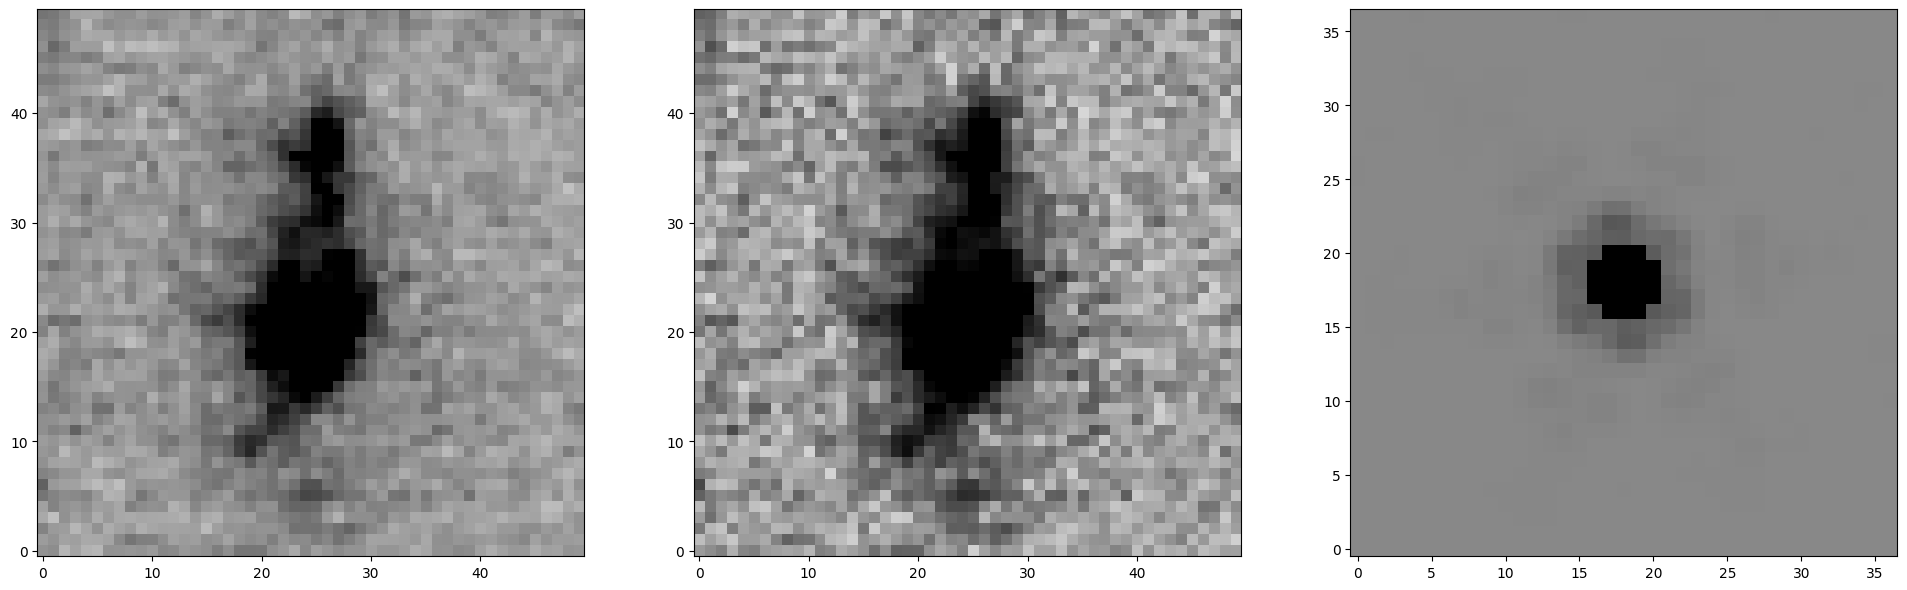

In [21]:
# test on single filter
im, mask, sig, psf = load_data(filter='f210m')
from pysersic.results import plot_image

fig, ax = plot_image(im, mask, sig, psf)

In [22]:
from pysersic.priors import autoprior

#prior  = autoprior(image = im, profile_type = 'sersic', mask=mask, sky_type = 'none')
props = SourceProperties(im, mask=mask) # Optional mask
prior = props.generate_prior('sersic', # Other profiles inclues 'exp', 'dev' and 'pointsource'
                          sky_type='none')
prior

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 38.68, sigma = 12.44
xc ---  Normal w/ mu = 24.23, sigma = 1.00
yc ---  Normal w/ mu = 21.34, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 8.32, sigma = 5.77, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.65 -> 8.00
sky type - None

In [23]:
# choose loss function & fit
from pysersic.loss import student_t_loss
fitter = FitSingle(data=im,rms=sig,mask=mask,psf=psf,prior=prior,loss_func=student_t_loss)

d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


In [24]:
# "retrieve a prediction for the best fit model very quickly, using SVI (stochastic variational inference)."
from jax.random import PRNGKey # Need to use a seed to start jax's random number generation
map_params = fitter.find_MAP(rkey = PRNGKey(1000))

  1%|▏         | 274/20000 [00:00<00:28, 702.37it/s, Round = 2,step_size = 5.0e-04 loss: -8.187e+03]


(50, 50)

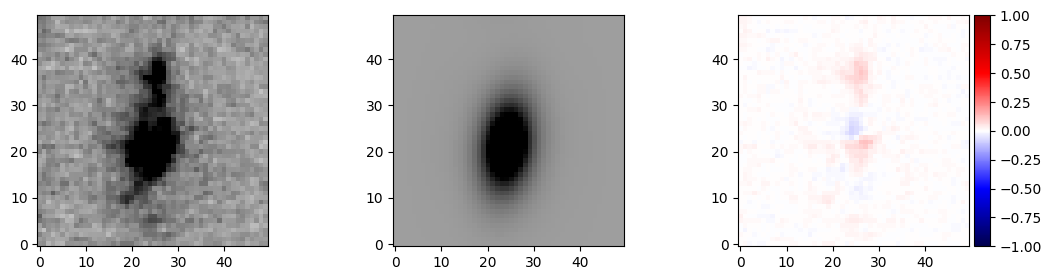

In [25]:

fig, ax = plot_residual(im,map_params['model'],mask=mask,vmin=-1,vmax=1, colorbar=False)

# fig, (ax1, ax2) = plt.subplots(2)
# fig.suptitle('Vertically stacked subplots')
# ax1.plot(x, y)
# ax2.plot(x, -y)

map_params['model'].shape

In [13]:
fitter.sample(rkey = PRNGKey(1000))
print(fitter.sampling_results.retrieve_param_quantiles(return_dataframe=True))

d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:20<00:00, 97.83it/s, 7 steps of size 4.12e-01. acc. prob=0.92]  


            0.16       0.50       0.84
ellip   0.476957   0.502171   0.526050
flux   24.987698  25.994226  26.866199
n       0.770561   0.835504   0.898491
r_eff   6.838532   7.118022   7.397978
theta   2.993975   3.019910   3.044858
xc     23.979158  24.090654  24.195563
yc     21.072980  21.270476  21.466498


In [14]:
# plot residual
summary = fitter.sampling_results.summary()
dict = {}
for a, b in zip(summary.index, summary["mean"]):
    dict[a] = b
# dict.pop('sys_scatter')   
dict
# fitter.sampling_results


{'ellip': 0.502,
 'flux': 25.942,
 'n': 0.836,
 'r_eff': 7.119,
 'theta': 3.019,
 'xc': 24.088,
 'yc': 21.271}

In [15]:
bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_sersic(dict)

C:\Users\kings\AppData\Local\Temp\ipykernel_20608\2566725324.py:1: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_sersic(dict)


In [16]:
# summary = fitter.sampling_results.summary()
# dict = {}
# for a, b in zip(summary.index, summary["mean"]):
#     dict[a] = b

# bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')
# print("corner of", ii_f.upper())
# fig = fitter.sampling_results.corner(color='C0') 
# plt.show()
# fig, ax = plot_residual(im, bf_model, mask = mask, vmin=-1, vmax=1)
# plt.show()

# Fit bands independently of each other

load data for filter F090W
data looks good!
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 13.03, sigma = 7.22
xc ---  Normal w/ mu = 24.56, sigma = 1.00
yc ---  Normal w/ mu = 21.42, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 6.94, sigma = 5.27, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.50 -> 4.50
sky type - None



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:23<00:00, 84.04it/s, 7 steps of size 3.25e-01. acc. prob=0.87]  


              0.16       0.50       0.84
ellip     0.360726   0.417134   0.472758
flux      6.365394   6.776170   7.201543
n         0.683770   0.746293   0.835315
r_eff     3.548310   3.813229   4.096496
sys_rms   0.000020   0.000066   0.000137
theta     2.647463   2.728426   2.806340
xc       24.382452  24.557801  24.731522
yc       20.595327  20.798059  20.990017


C:\Users\kings\AppData\Local\Temp\ipykernel_13280\3612776576.py:37: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')


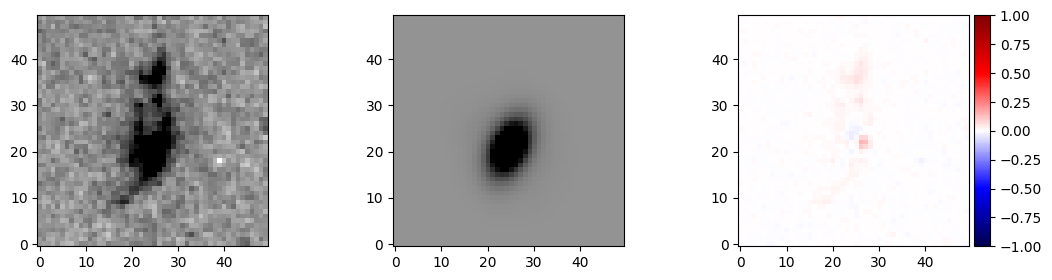

corner of F090W


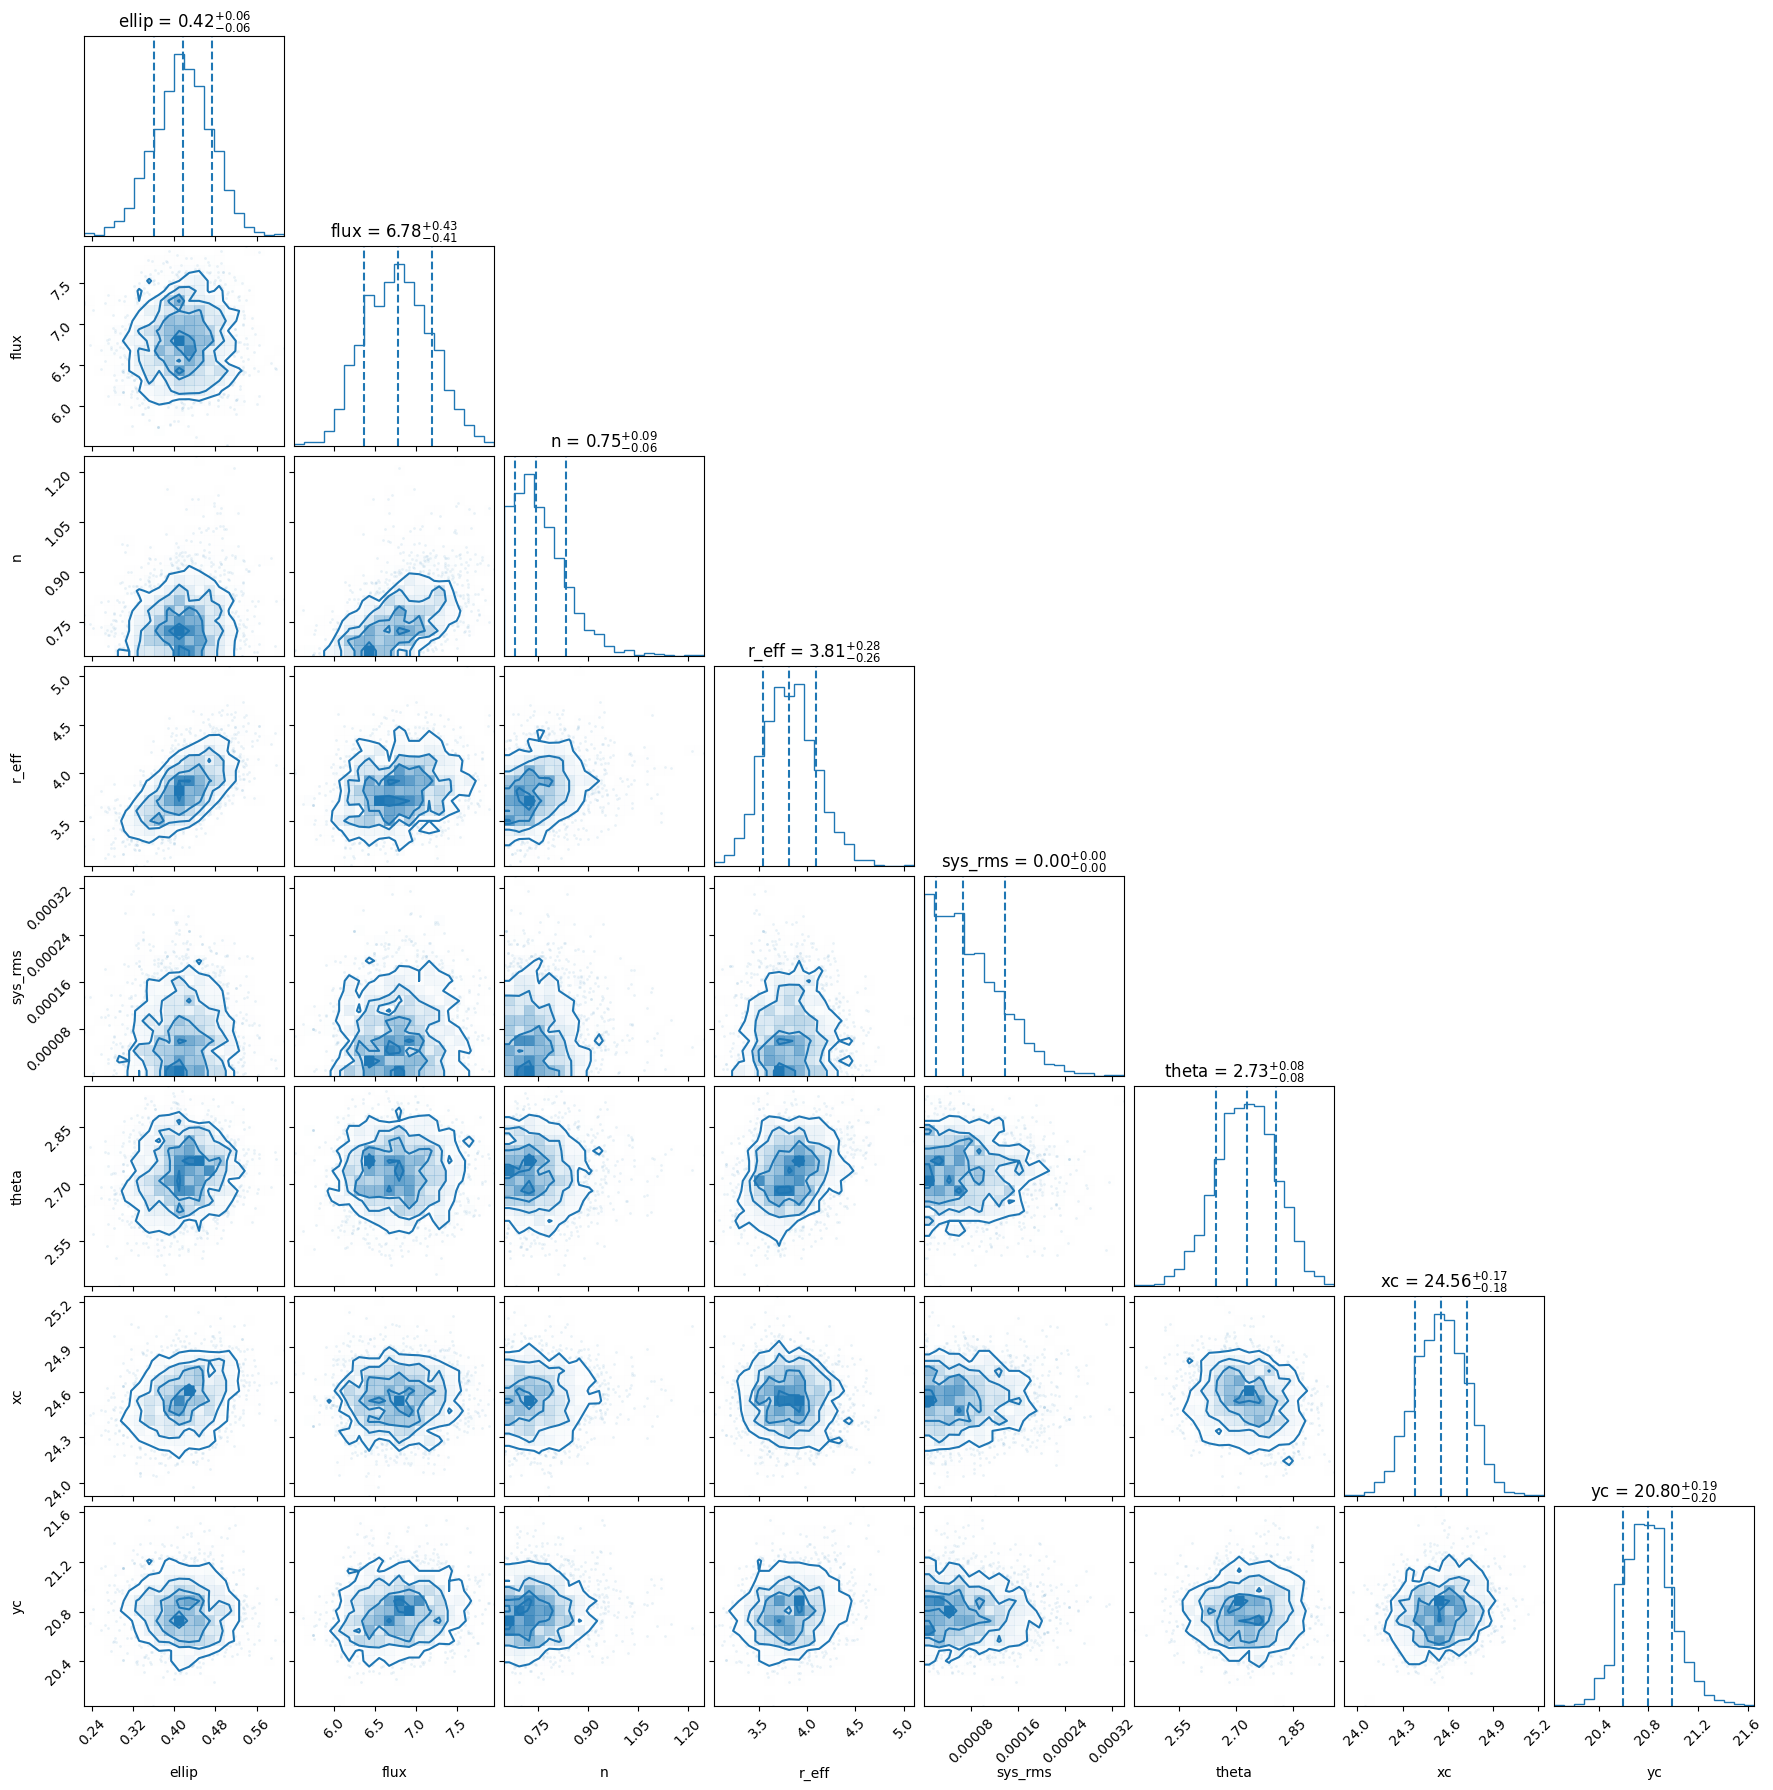

load data for filter F115W
data looks good!
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 25.92, sigma = 10.18
xc ---  Normal w/ mu = 24.29, sigma = 1.00
yc ---  Normal w/ mu = 21.71, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 8.55, sigma = 5.85, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.50 -> 4.50
sky type - None



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:20<00:00, 96.99it/s, 3 steps of size 4.55e-01. acc. prob=0.88]  


              0.16       0.50       0.84
ellip     0.397136   0.431881   0.464906
flux     14.996714  15.555552  16.078386
n         0.989746   1.093117   1.221258
r_eff     5.505031   5.819228   6.187222
sys_rms   0.000033   0.000091   0.000169
theta     2.789089   2.841951   2.896291
xc       23.921366  24.068889  24.228801
yc       20.716050  20.904081  21.102350


C:\Users\kings\AppData\Local\Temp\ipykernel_13280\3612776576.py:37: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')


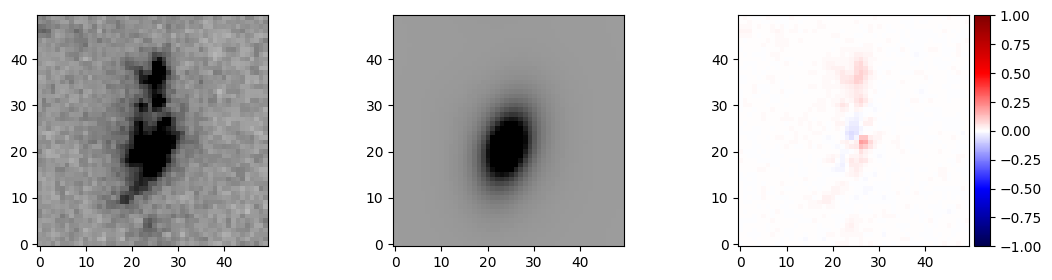

corner of F115W


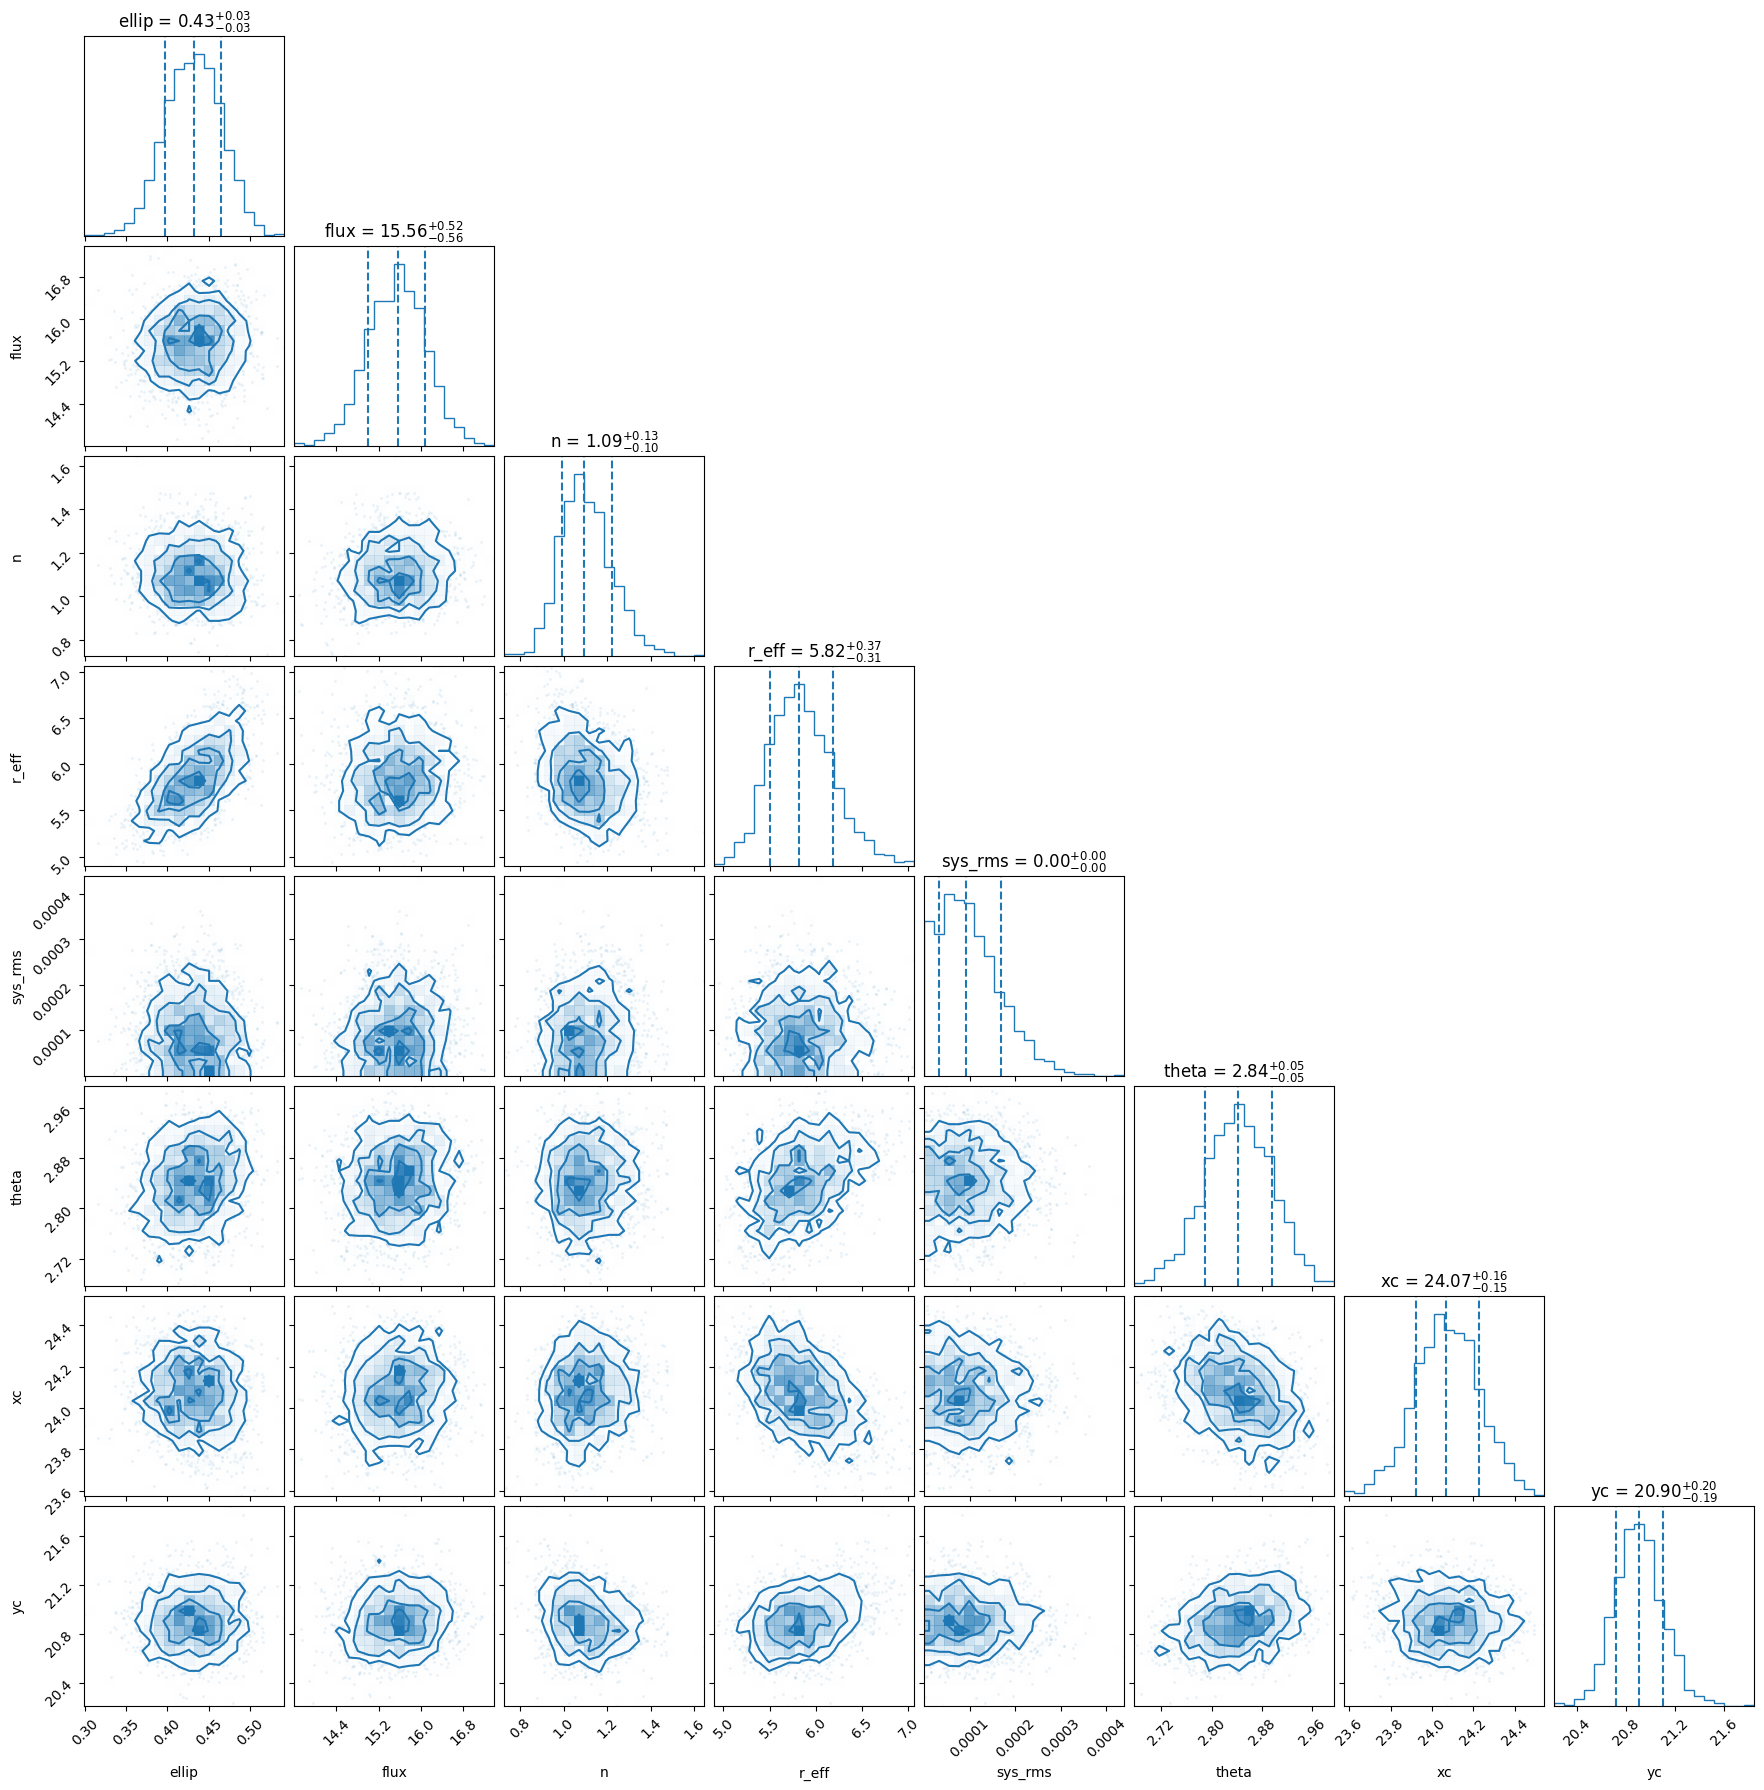

load data for filter F150W
data looks good!
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 28.43, sigma = 10.66
xc ---  Normal w/ mu = 24.30, sigma = 1.00
yc ---  Normal w/ mu = 21.59, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 8.10, sigma = 5.69, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.50 -> 4.50
sky type - None



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:23<00:00, 86.16it/s, 3 steps of size 4.86e-01. acc. prob=0.85]  


              0.16       0.50       0.84
ellip     0.454841   0.485775   0.516085
flux     17.753069  18.436740  19.054642
n         0.896283   0.981178   1.086787
r_eff     5.930973   6.259207   6.634392
sys_rms   0.000111   0.000209   0.000292
theta     2.847520   2.883888   2.918794
xc       23.963758  24.088367  24.212909
yc       20.928054  21.128222  21.350087


C:\Users\kings\AppData\Local\Temp\ipykernel_13280\3612776576.py:37: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')


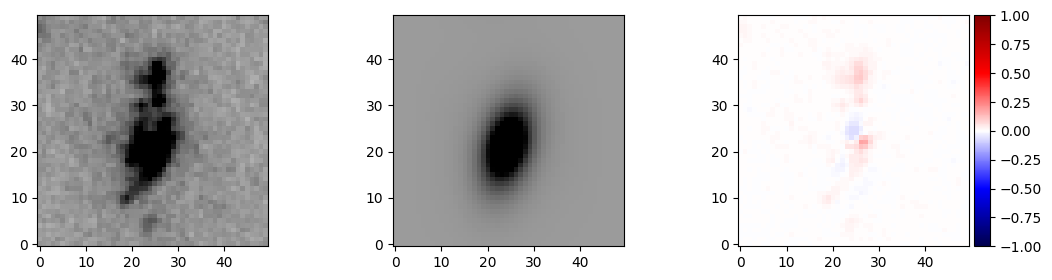

corner of F150W


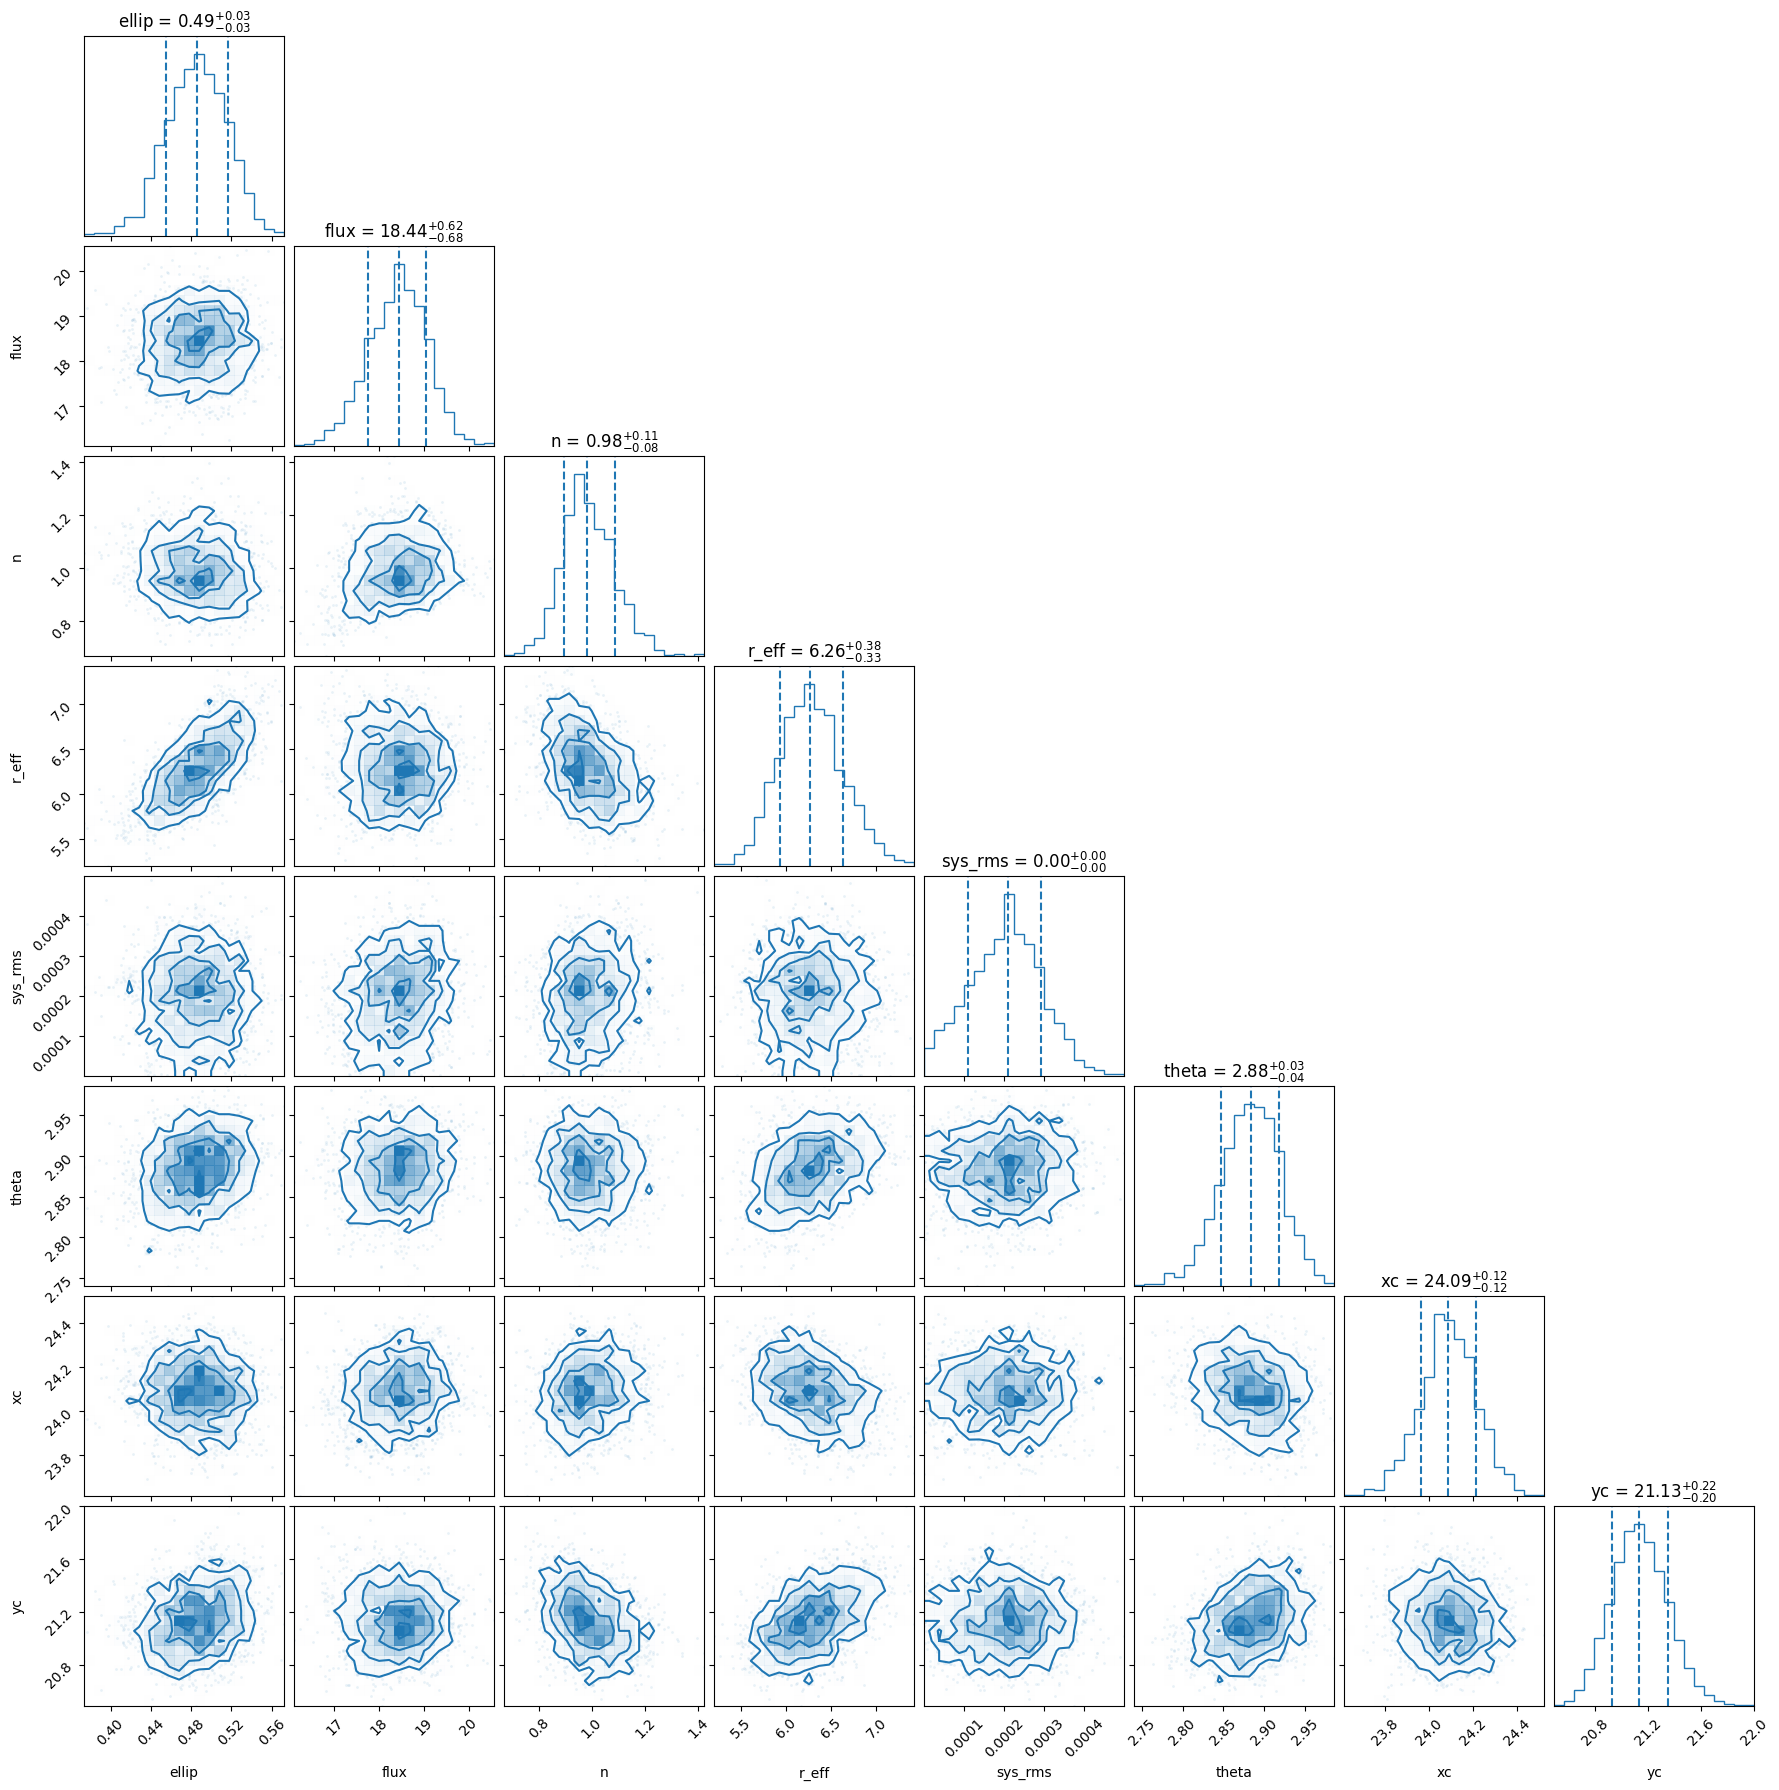

load data for filter F182M
data looks good!
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 32.02, sigma = 11.32
xc ---  Normal w/ mu = 24.35, sigma = 1.00
yc ---  Normal w/ mu = 21.44, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 8.03, sigma = 5.67, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.50 -> 4.50
sky type - None



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:25<00:00, 77.99it/s, 7 steps of size 3.48e-01. acc. prob=0.92]  


              0.16       0.50       0.84
ellip     0.466910   0.496197   0.522978
flux     20.391220  21.263842  22.018944
n         0.769998   0.840843   0.908357
r_eff     5.996547   6.315768   6.643572
sys_rms   0.000017   0.000059   0.000130
theta     2.897066   2.932546   2.964577
xc       24.291158  24.404499  24.513860
yc       21.042657  21.256889  21.492469


C:\Users\kings\AppData\Local\Temp\ipykernel_13280\3612776576.py:37: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')


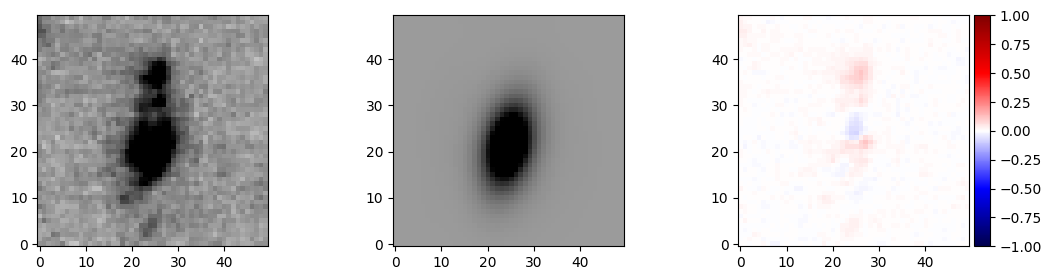

corner of F182M


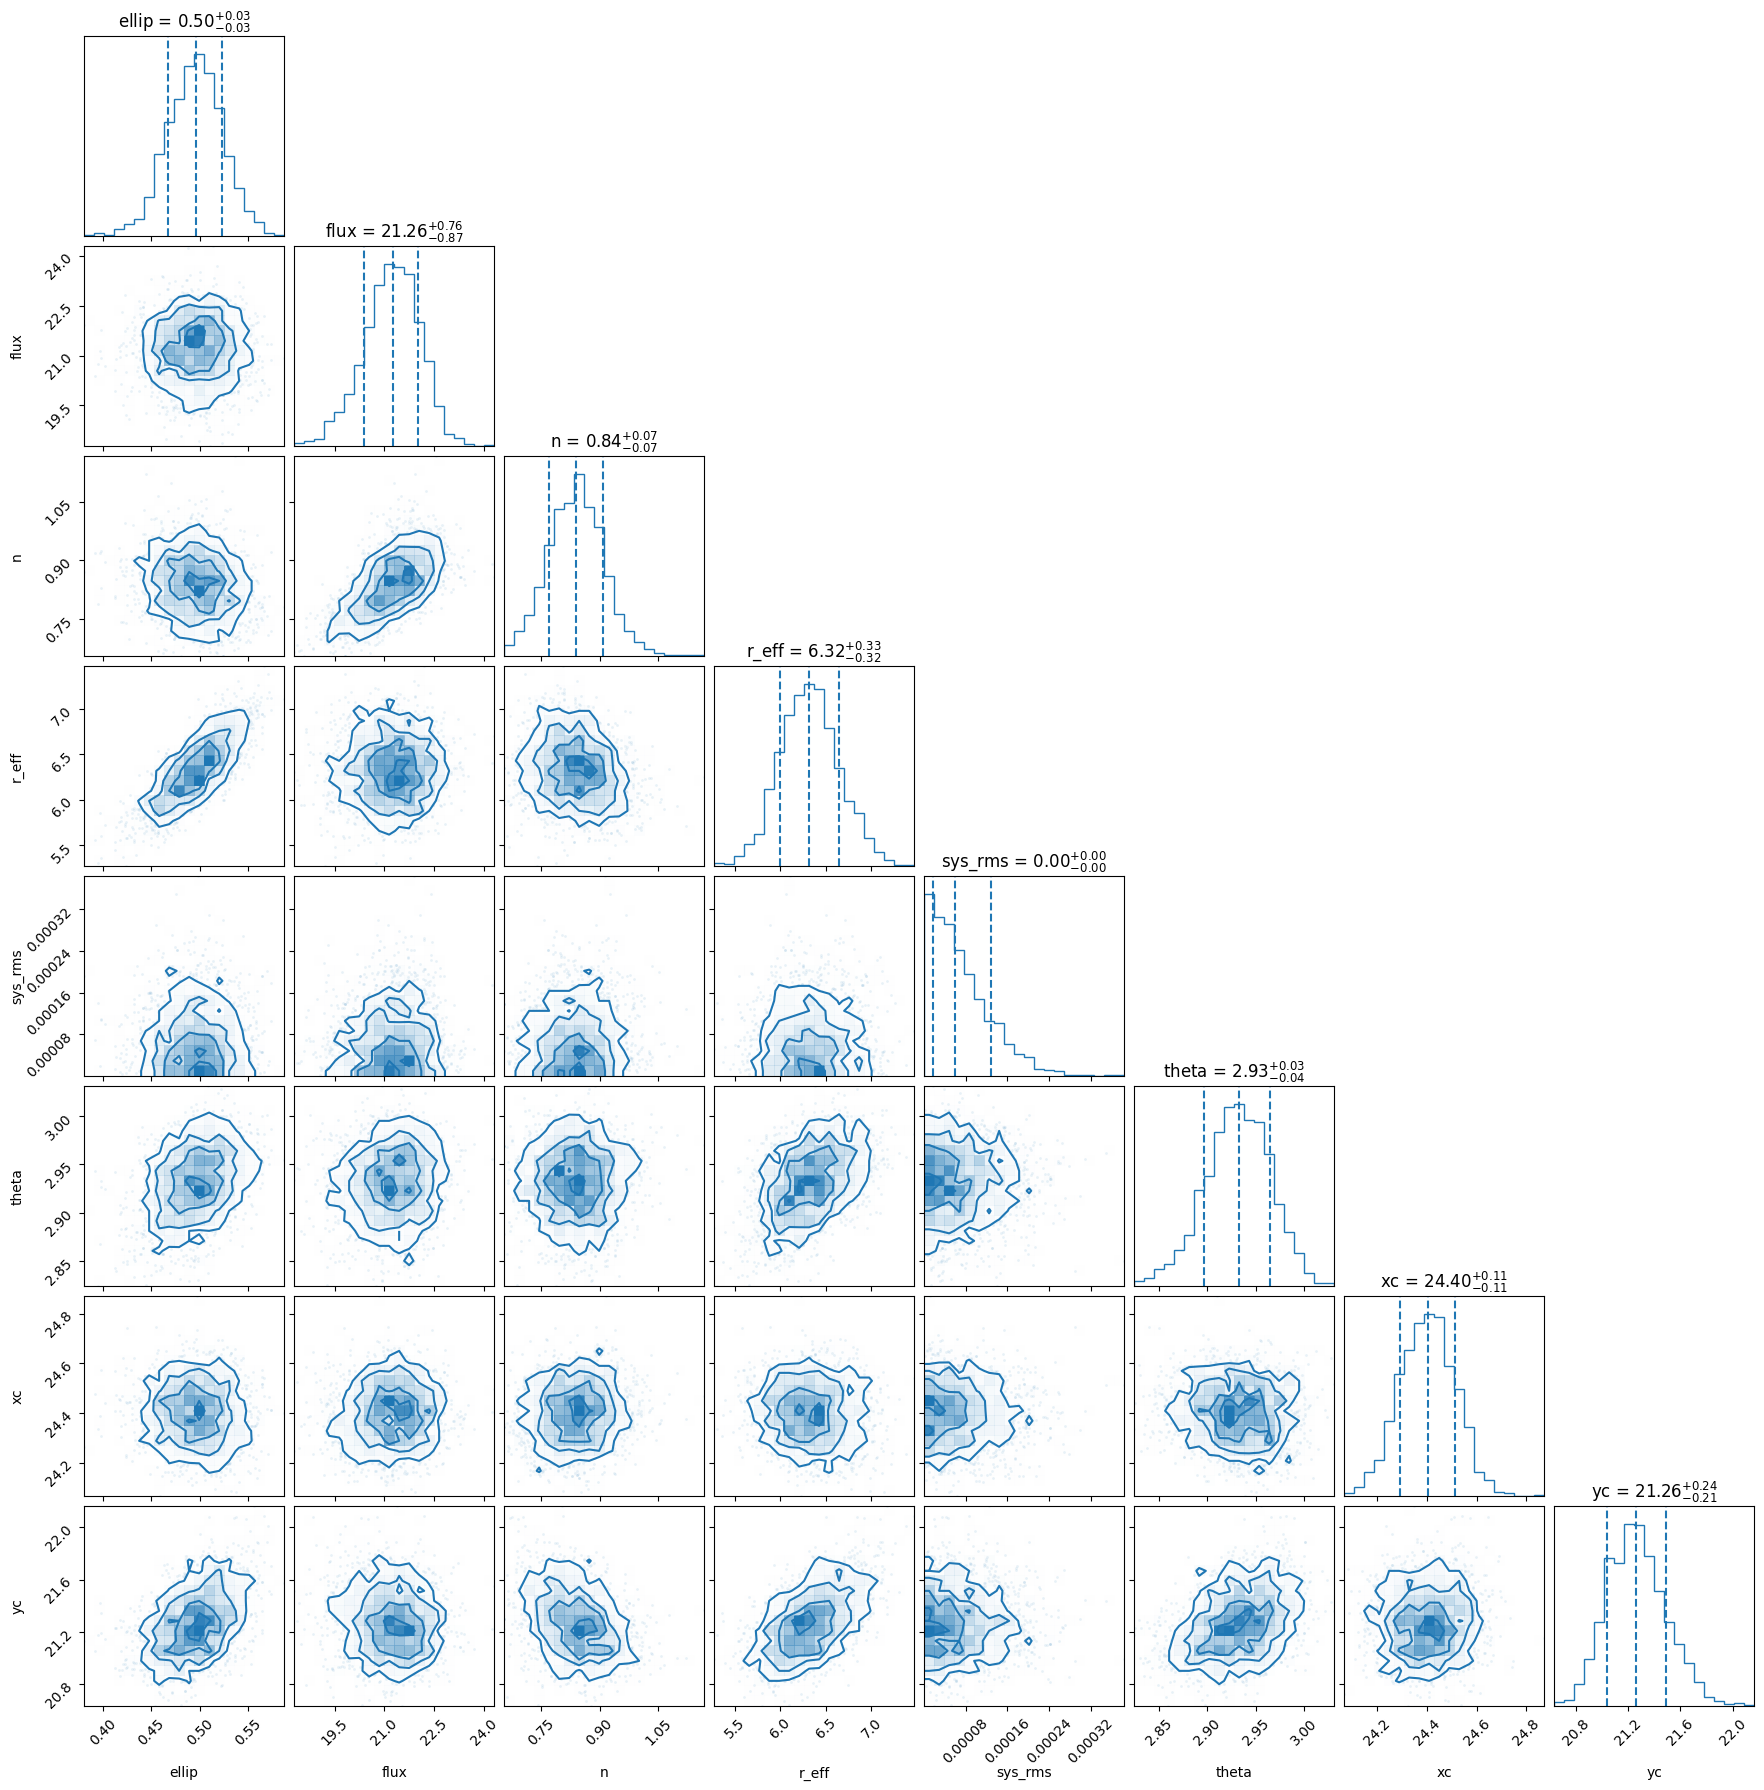

load data for filter F200W
data looks good!
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 36.67, sigma = 12.11
xc ---  Normal w/ mu = 24.07, sigma = 1.00
yc ---  Normal w/ mu = 21.41, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 8.27, sigma = 5.75, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.50 -> 4.50
sky type - None



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:24<00:00, 83.06it/s, 7 steps of size 3.57e-01. acc. prob=0.90]  


              0.16       0.50       0.84
ellip     0.464996   0.490699   0.513234
flux     25.301424  26.344728  27.199404
n         0.791210   0.866836   0.944254
r_eff     7.327601   7.680424   7.979636
sys_rms   0.000095   0.000200   0.000295
theta     3.005126   3.029990   3.056254
xc       23.733908  23.843789  23.948221
yc       21.070162  21.301103  21.563622


C:\Users\kings\AppData\Local\Temp\ipykernel_13280\3612776576.py:37: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')


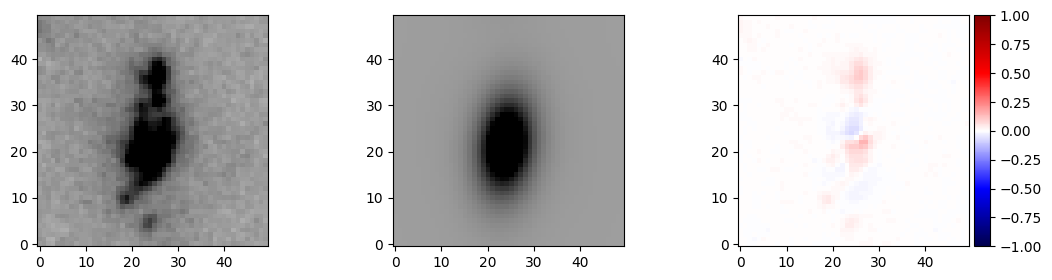

corner of F200W


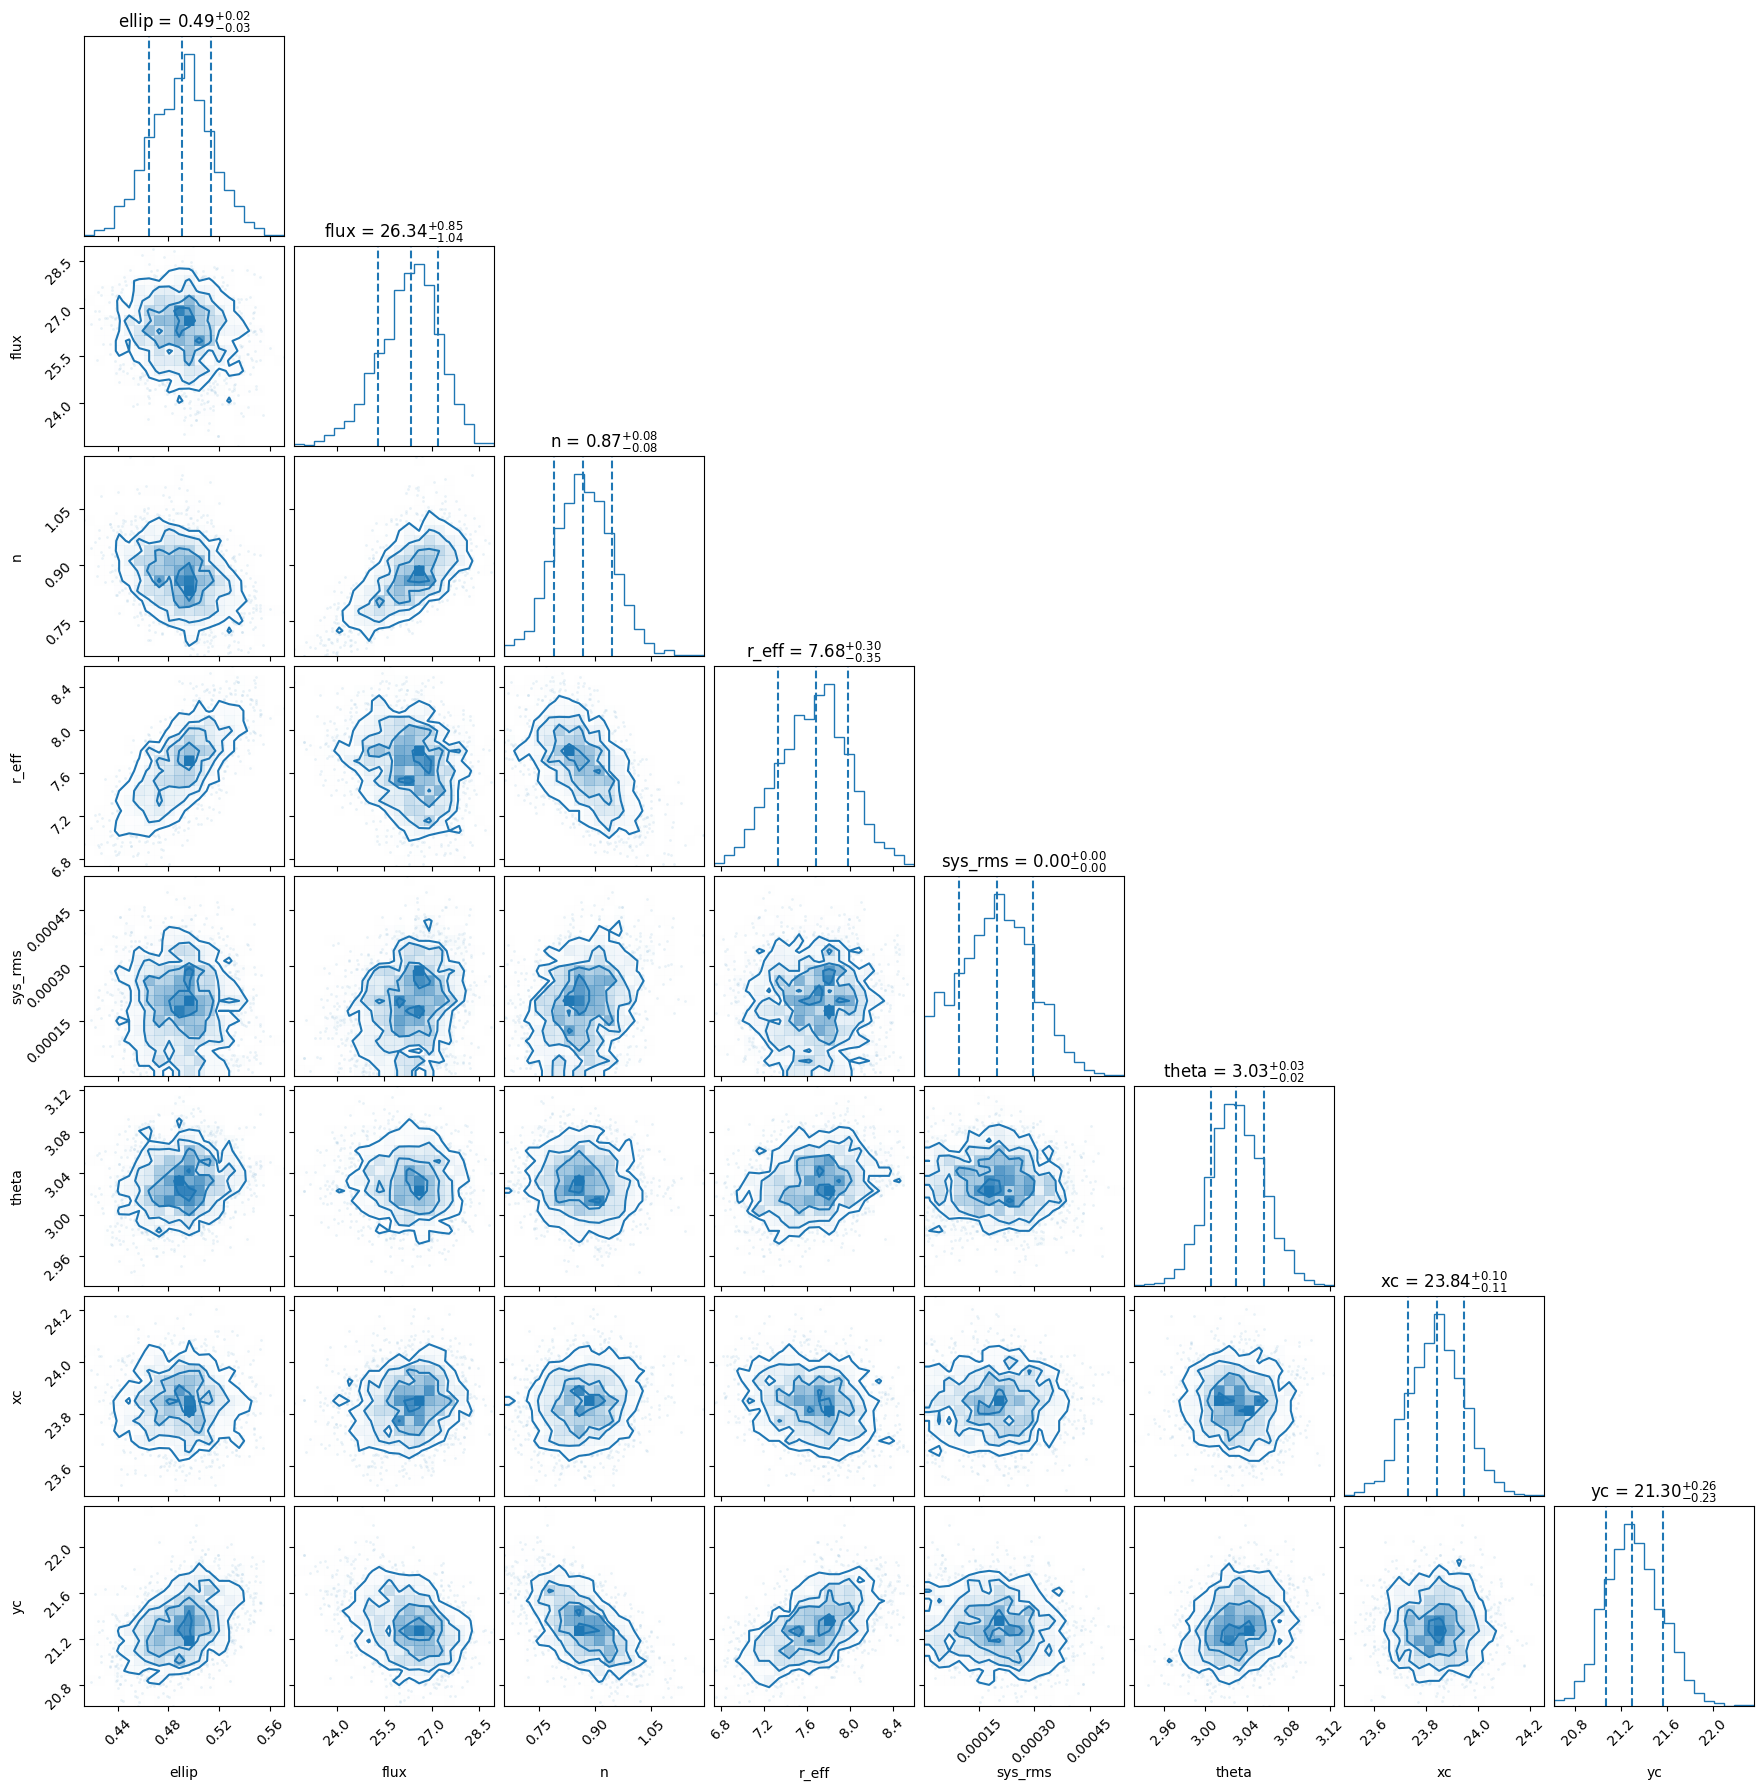

load data for filter F210M
data looks good!
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 38.68, sigma = 12.44
xc ---  Normal w/ mu = 24.23, sigma = 1.00
yc ---  Normal w/ mu = 21.34, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 8.32, sigma = 5.77, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.50 -> 4.50
sky type - None



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:22<00:00, 90.04it/s, 7 steps of size 4.38e-01. acc. prob=0.87]  


              0.16       0.50       0.84
ellip     0.473366   0.500352   0.525017
flux     25.069832  26.095009  26.908659
n         0.779699   0.843946   0.907093
r_eff     6.822640   7.104800   7.401606
sys_rms   0.000032   0.000104   0.000210
theta     2.995090   3.019677   3.044231
xc       23.989902  24.091566  24.198525
yc       21.066314  21.255280  21.449058


C:\Users\kings\AppData\Local\Temp\ipykernel_13280\3612776576.py:37: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')


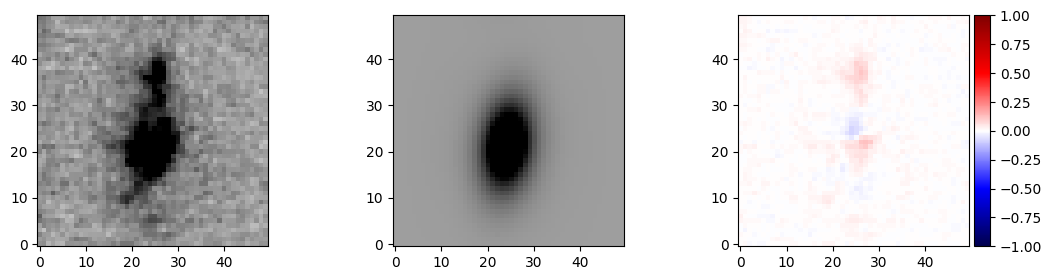

corner of F210M


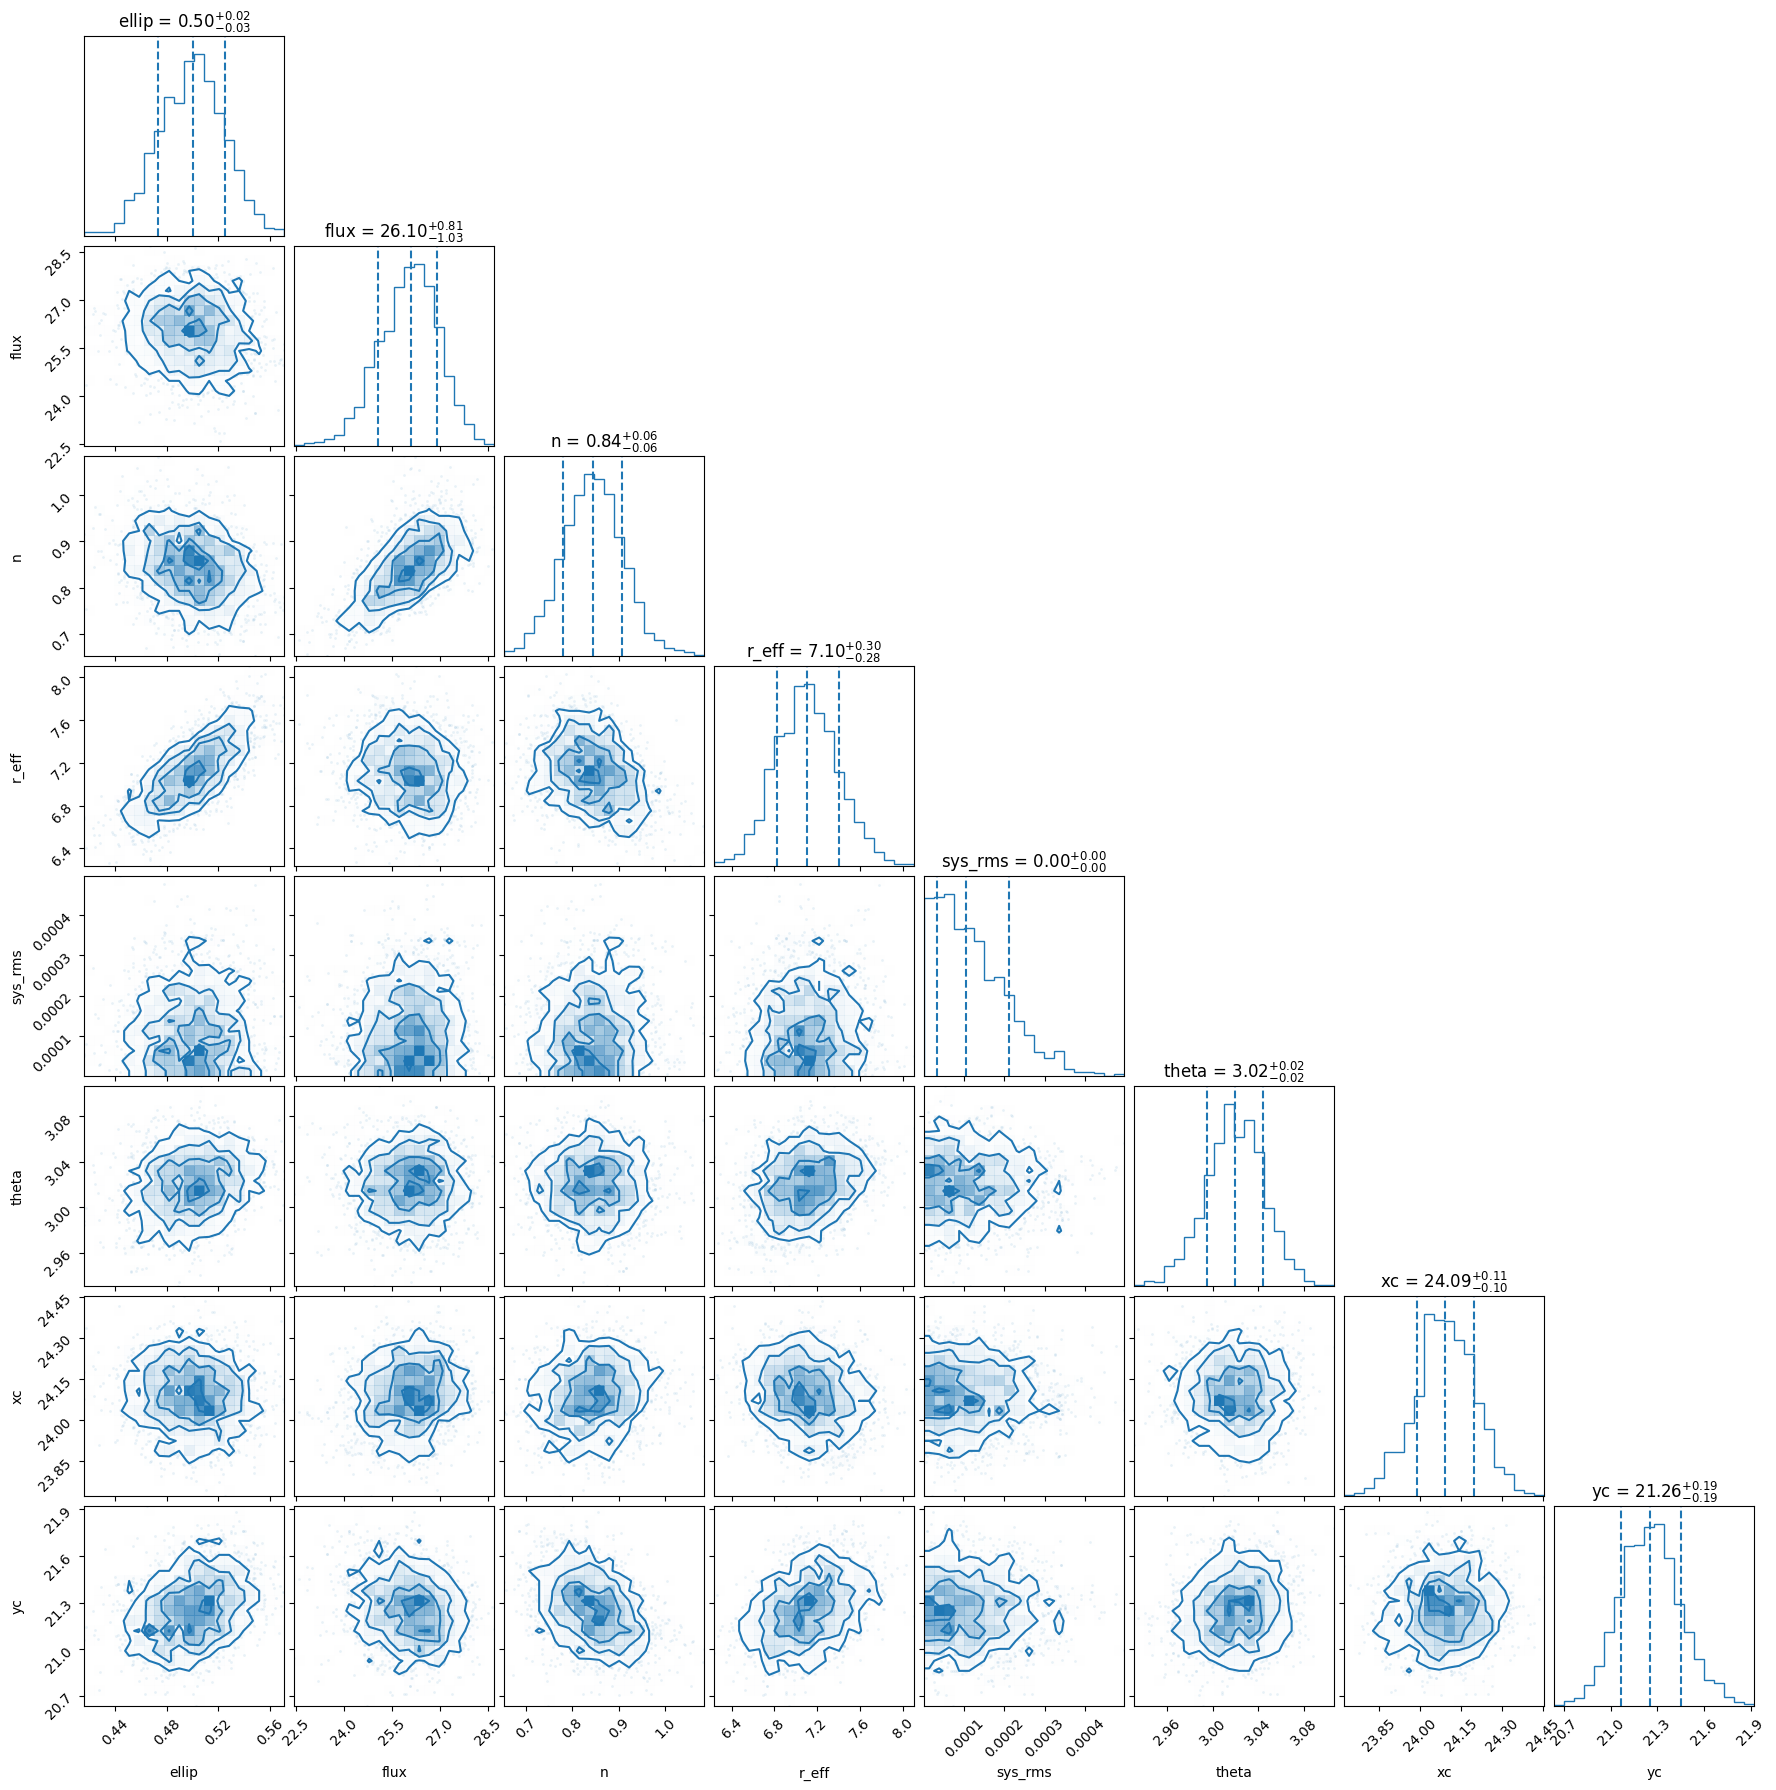

load data for filter F277W
data looks good!
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 65.36, sigma = 16.17
xc ---  Normal w/ mu = 23.86, sigma = 1.00
yc ---  Normal w/ mu = 21.22, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 9.22, sigma = 6.07, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.50 -> 4.50
sky type - None



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:24<00:00, 80.10it/s, 7 steps of size 3.92e-01. acc. prob=0.89]  


              0.16       0.50       0.84
ellip     0.403584   0.421867   0.439785
flux     56.565803  57.522432  58.452324
n         1.317731   1.384049   1.455653
r_eff     8.671357   8.887603   9.111718
sys_rms   0.000122   0.000257   0.000379
theta     3.068016   3.093148   3.118959
xc       23.688013  23.771663  23.851374
yc       20.753821  20.890968  21.028761


C:\Users\kings\AppData\Local\Temp\ipykernel_13280\3612776576.py:37: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')


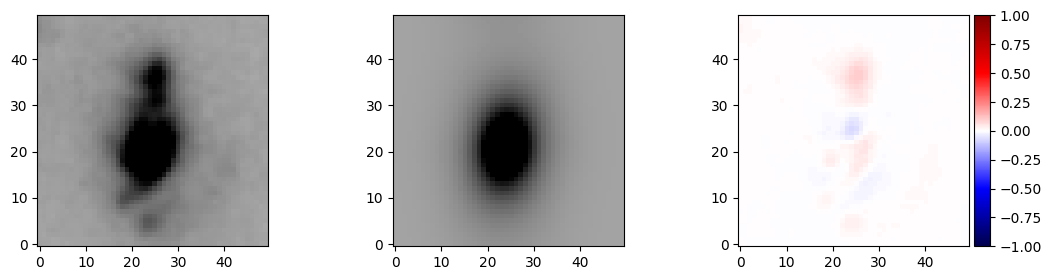

corner of F277W


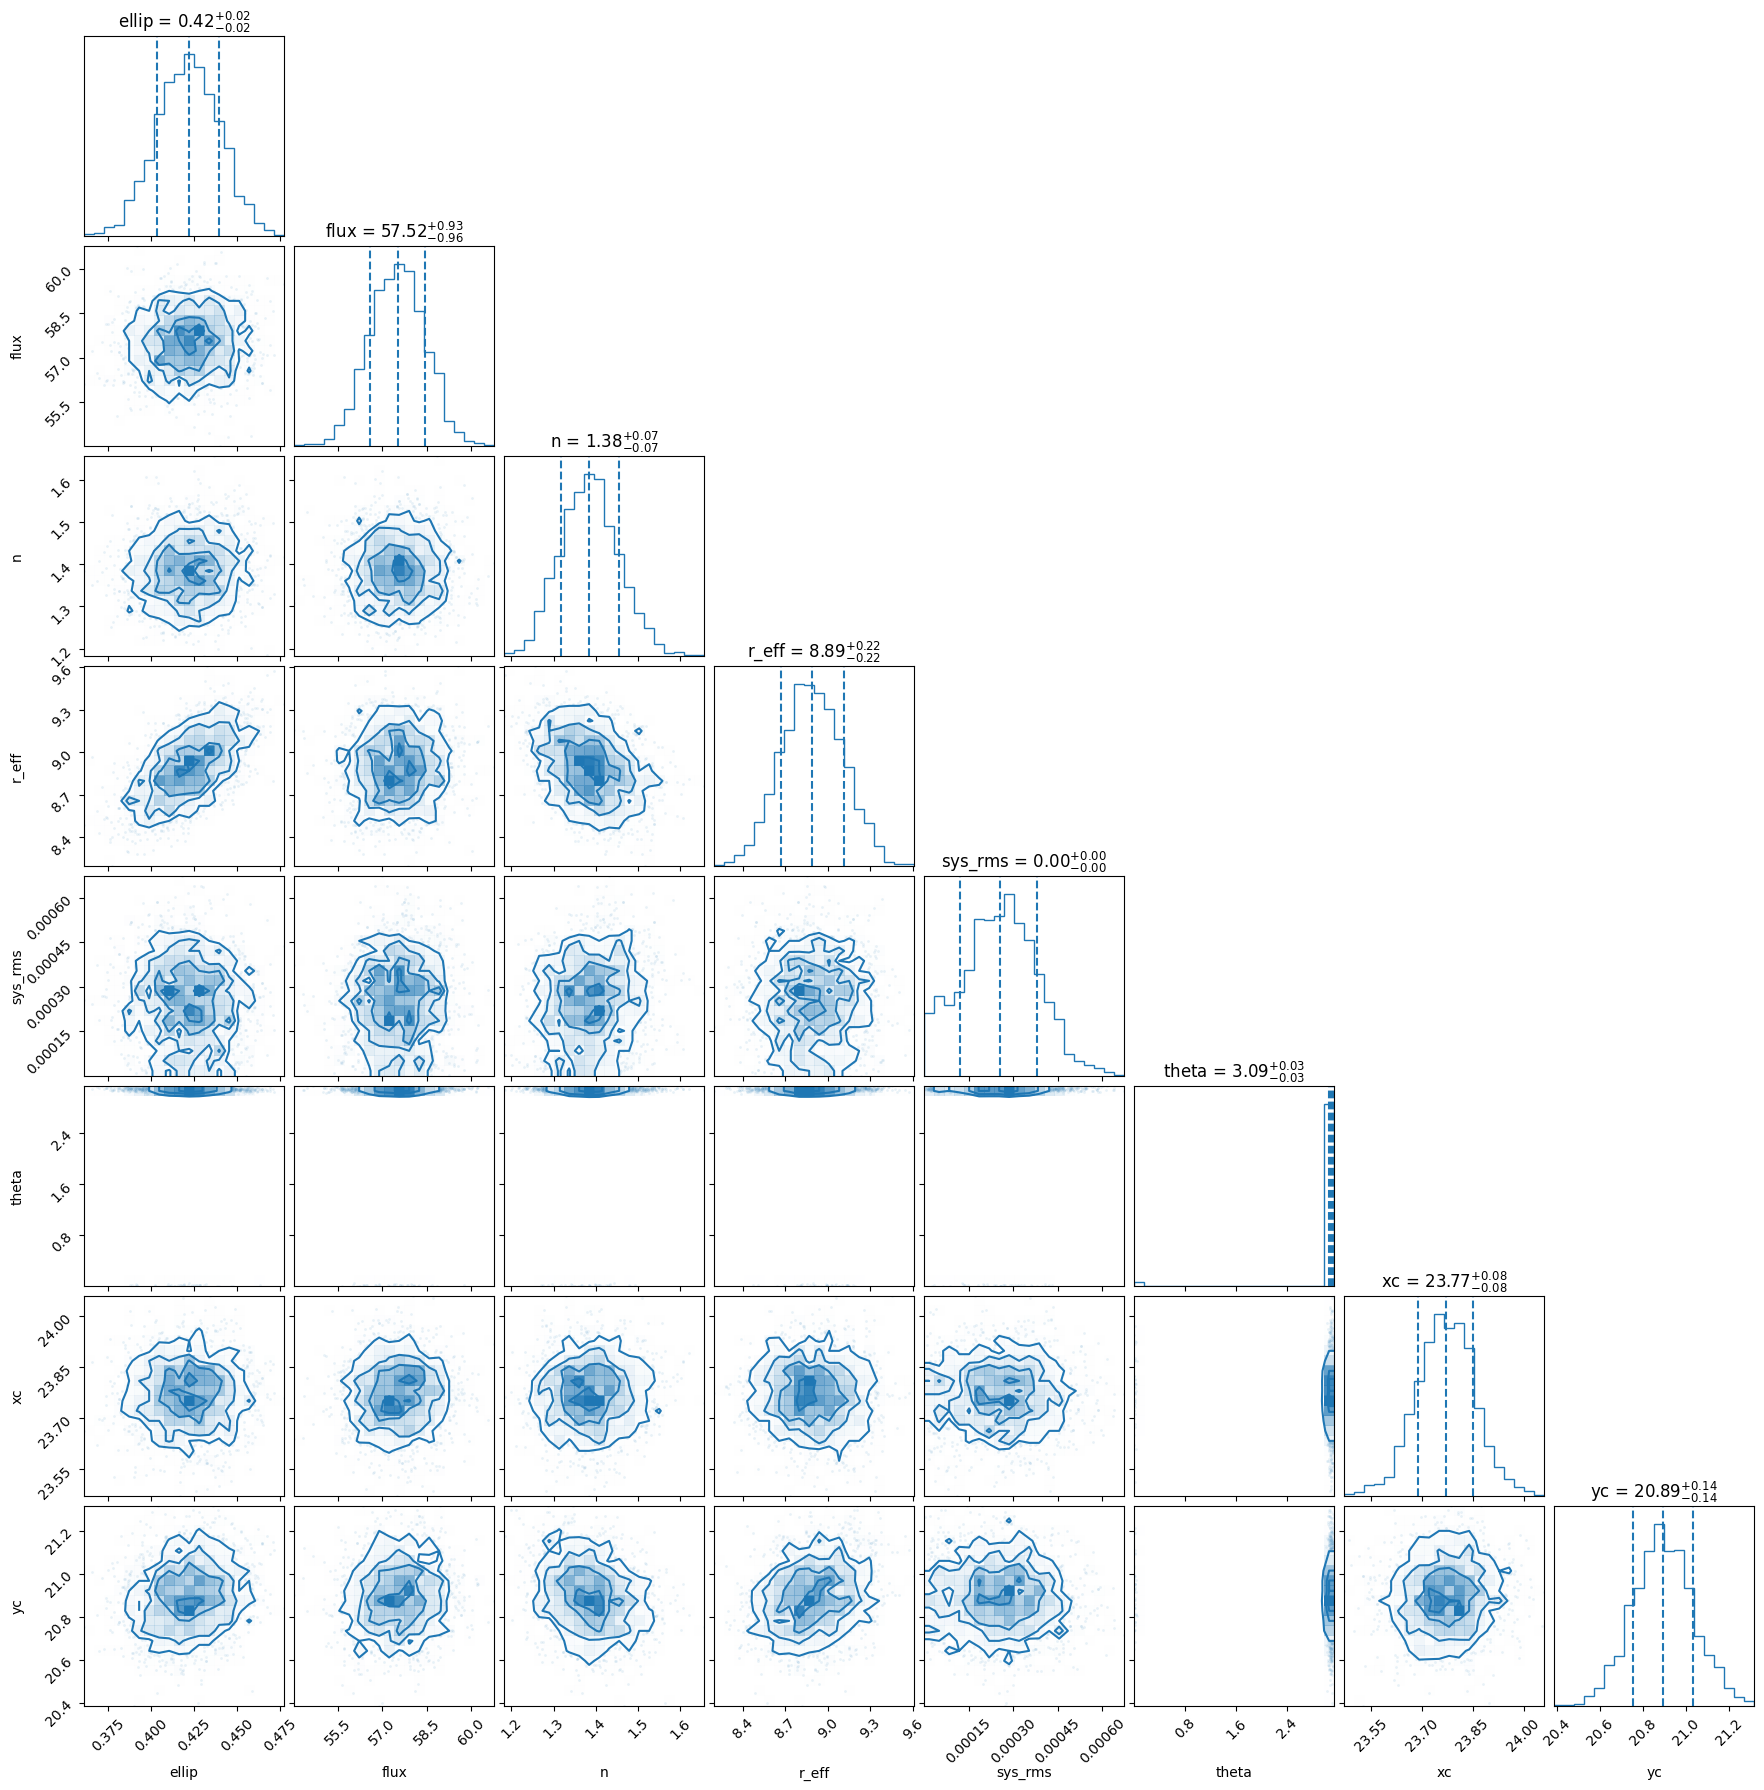

load data for filter F356W
data looks good!
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 75.42, sigma = 17.37
xc ---  Normal w/ mu = 23.91, sigma = 1.00
yc ---  Normal w/ mu = 21.17, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 9.83, sigma = 6.27, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.50 -> 4.50
sky type - None



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:27<00:00, 72.35it/s, 7 steps of size 2.96e-01. acc. prob=0.93] 


              0.16       0.50       0.84
ellip     0.418749   0.434272   0.451458
flux     66.129614  67.140820  68.048036
n         1.162211   1.220695   1.282354
r_eff     9.289252   9.495090   9.688008
sys_rms   0.000054   0.000201   0.000387
theta     3.073861   3.097328   3.119664
xc       23.684734  23.765544  23.851889
yc       20.683880  20.840337  20.990521


C:\Users\kings\AppData\Local\Temp\ipykernel_13280\3612776576.py:37: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')


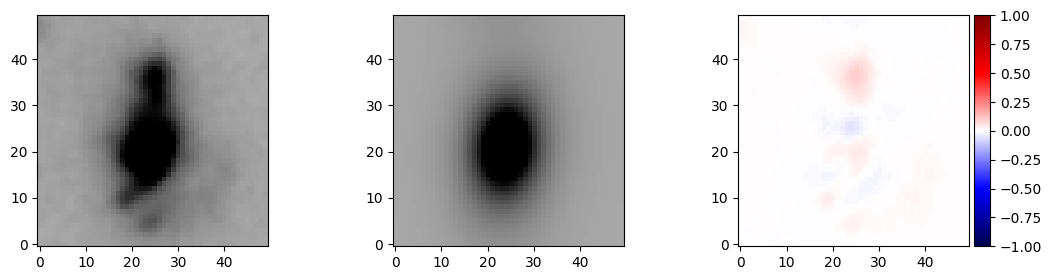

corner of F356W


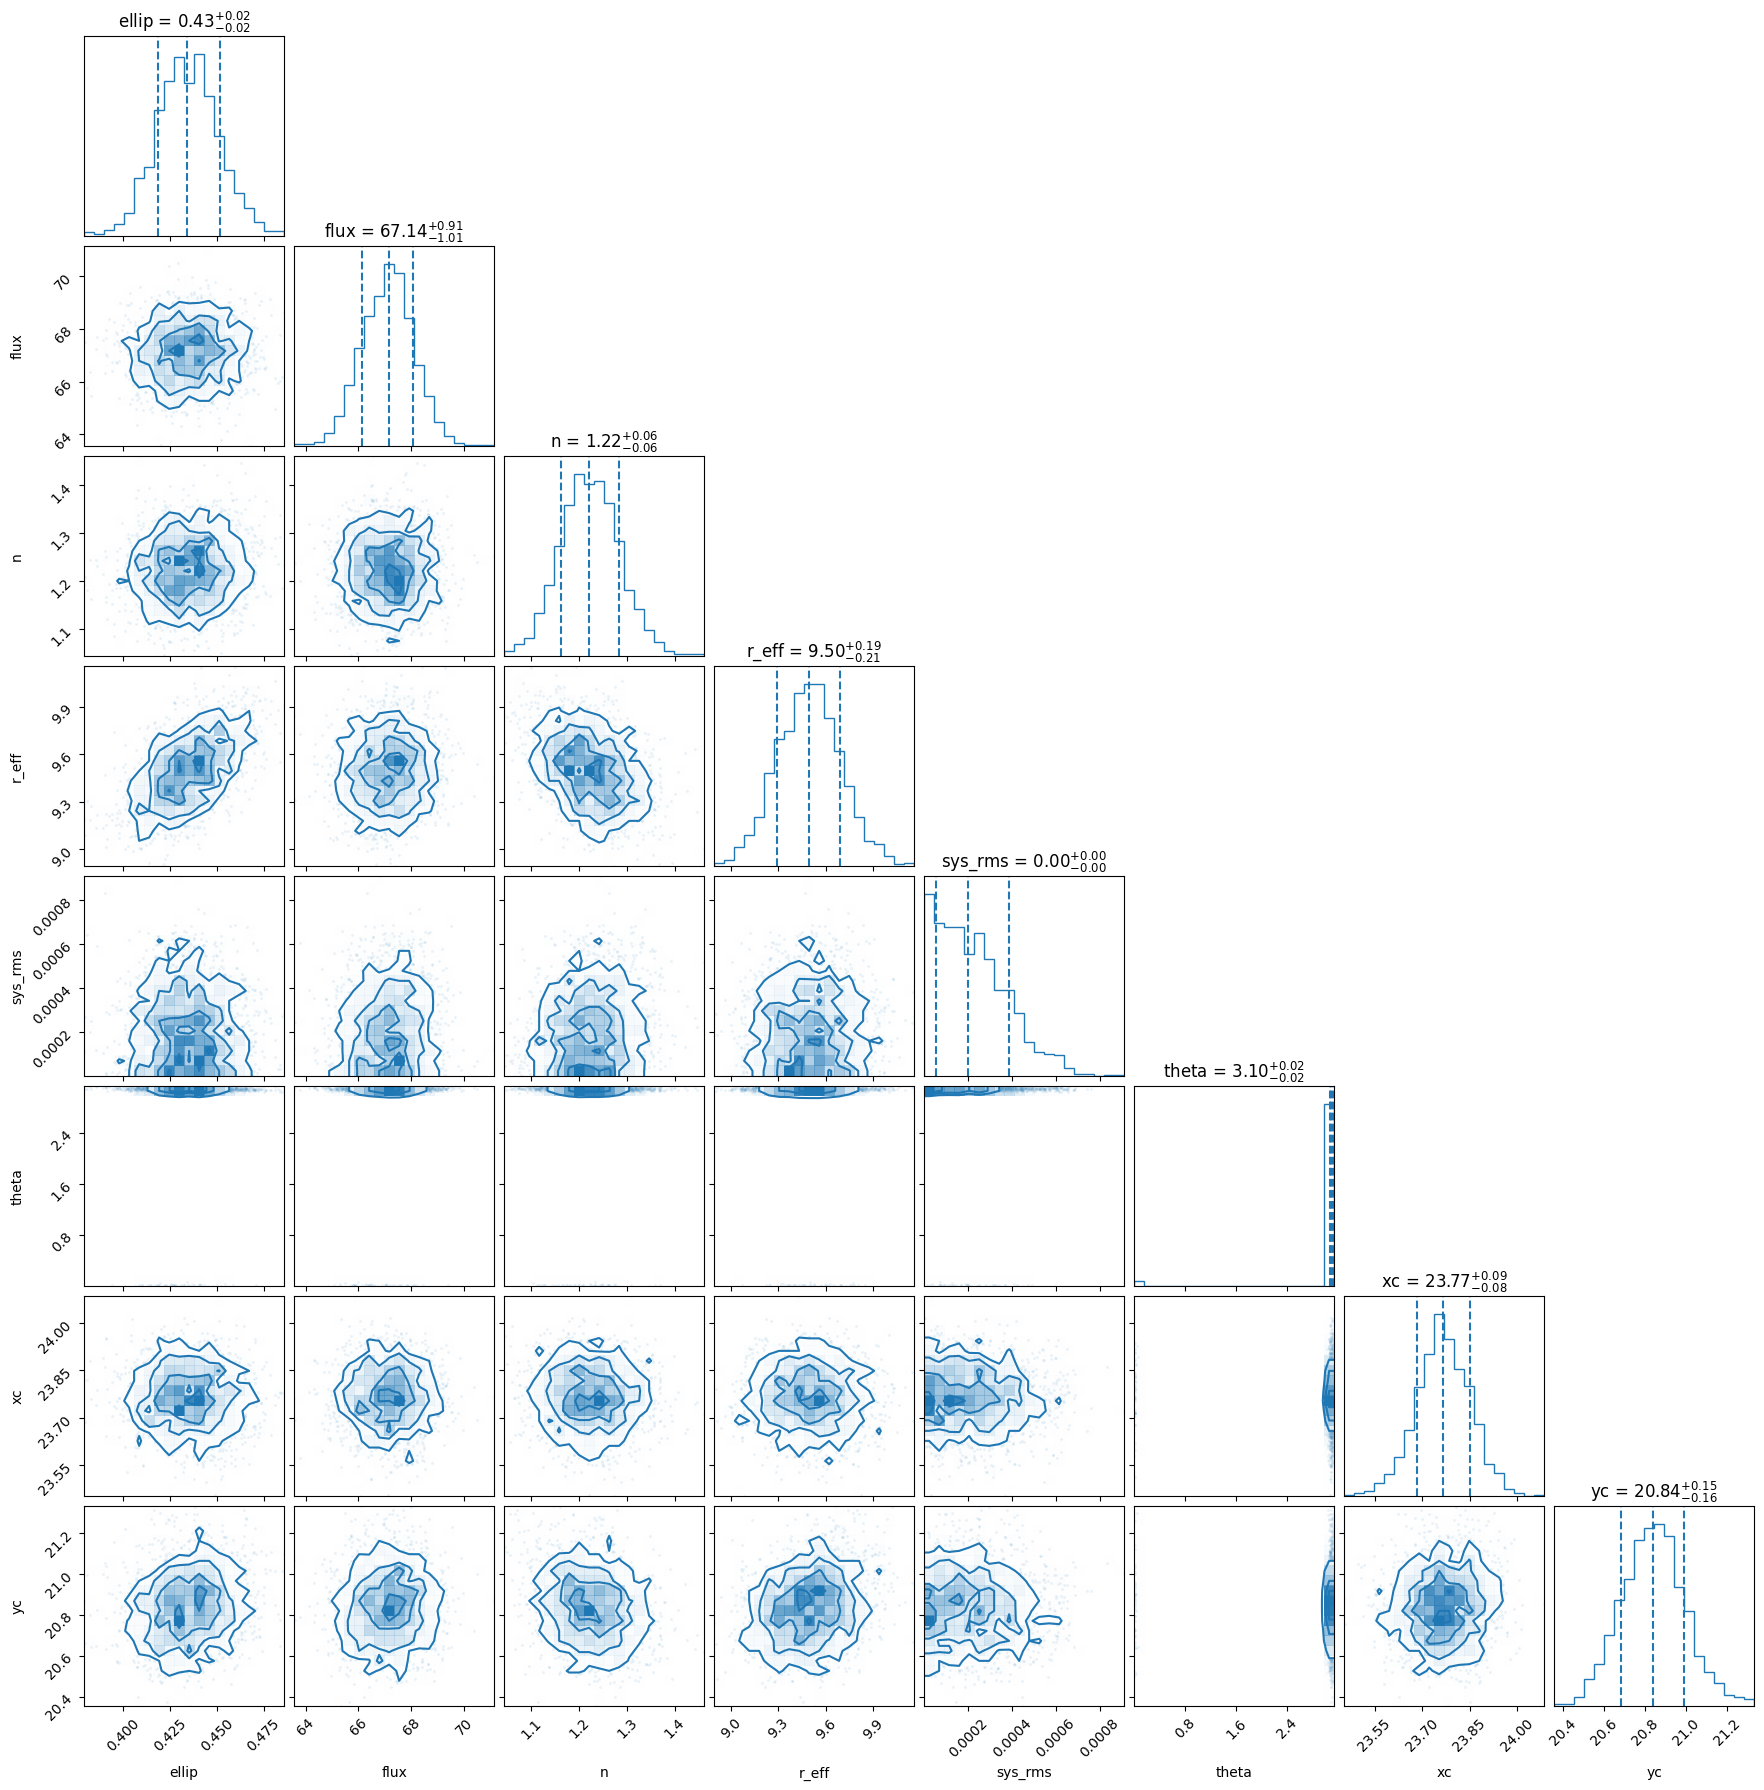

load data for filter F410M
data looks good!
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 112.82, sigma = 21.24
xc ---  Normal w/ mu = 24.11, sigma = 1.00
yc ---  Normal w/ mu = 21.12, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 10.14, sigma = 6.37, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.50 -> 4.50
sky type - None



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:25<00:00, 79.31it/s, 7 steps of size 3.43e-01. acc. prob=0.92]  


               0.16        0.50        0.84
ellip      0.421753    0.434370    0.448971
flux     100.627253  101.903191  103.083240
n          1.090057    1.138752    1.191011
r_eff      9.708200    9.877146   10.043249
sys_rms    0.000147    0.000398    0.000625
theta      3.076017    3.096929    3.116230
xc        23.929820   23.999671   24.070171
yc        20.604209   20.740653   20.878384


C:\Users\kings\AppData\Local\Temp\ipykernel_13280\3612776576.py:37: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')


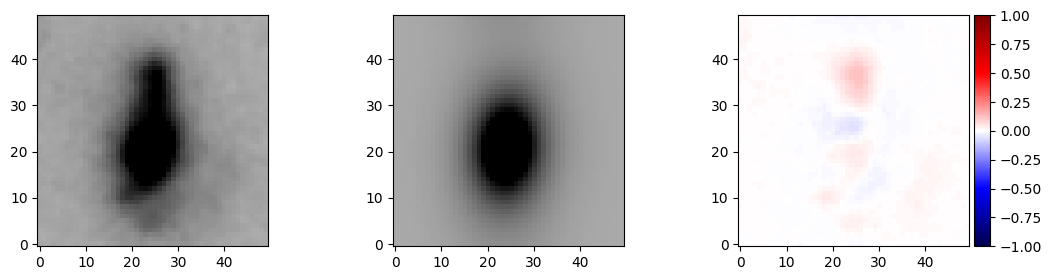

corner of F410M


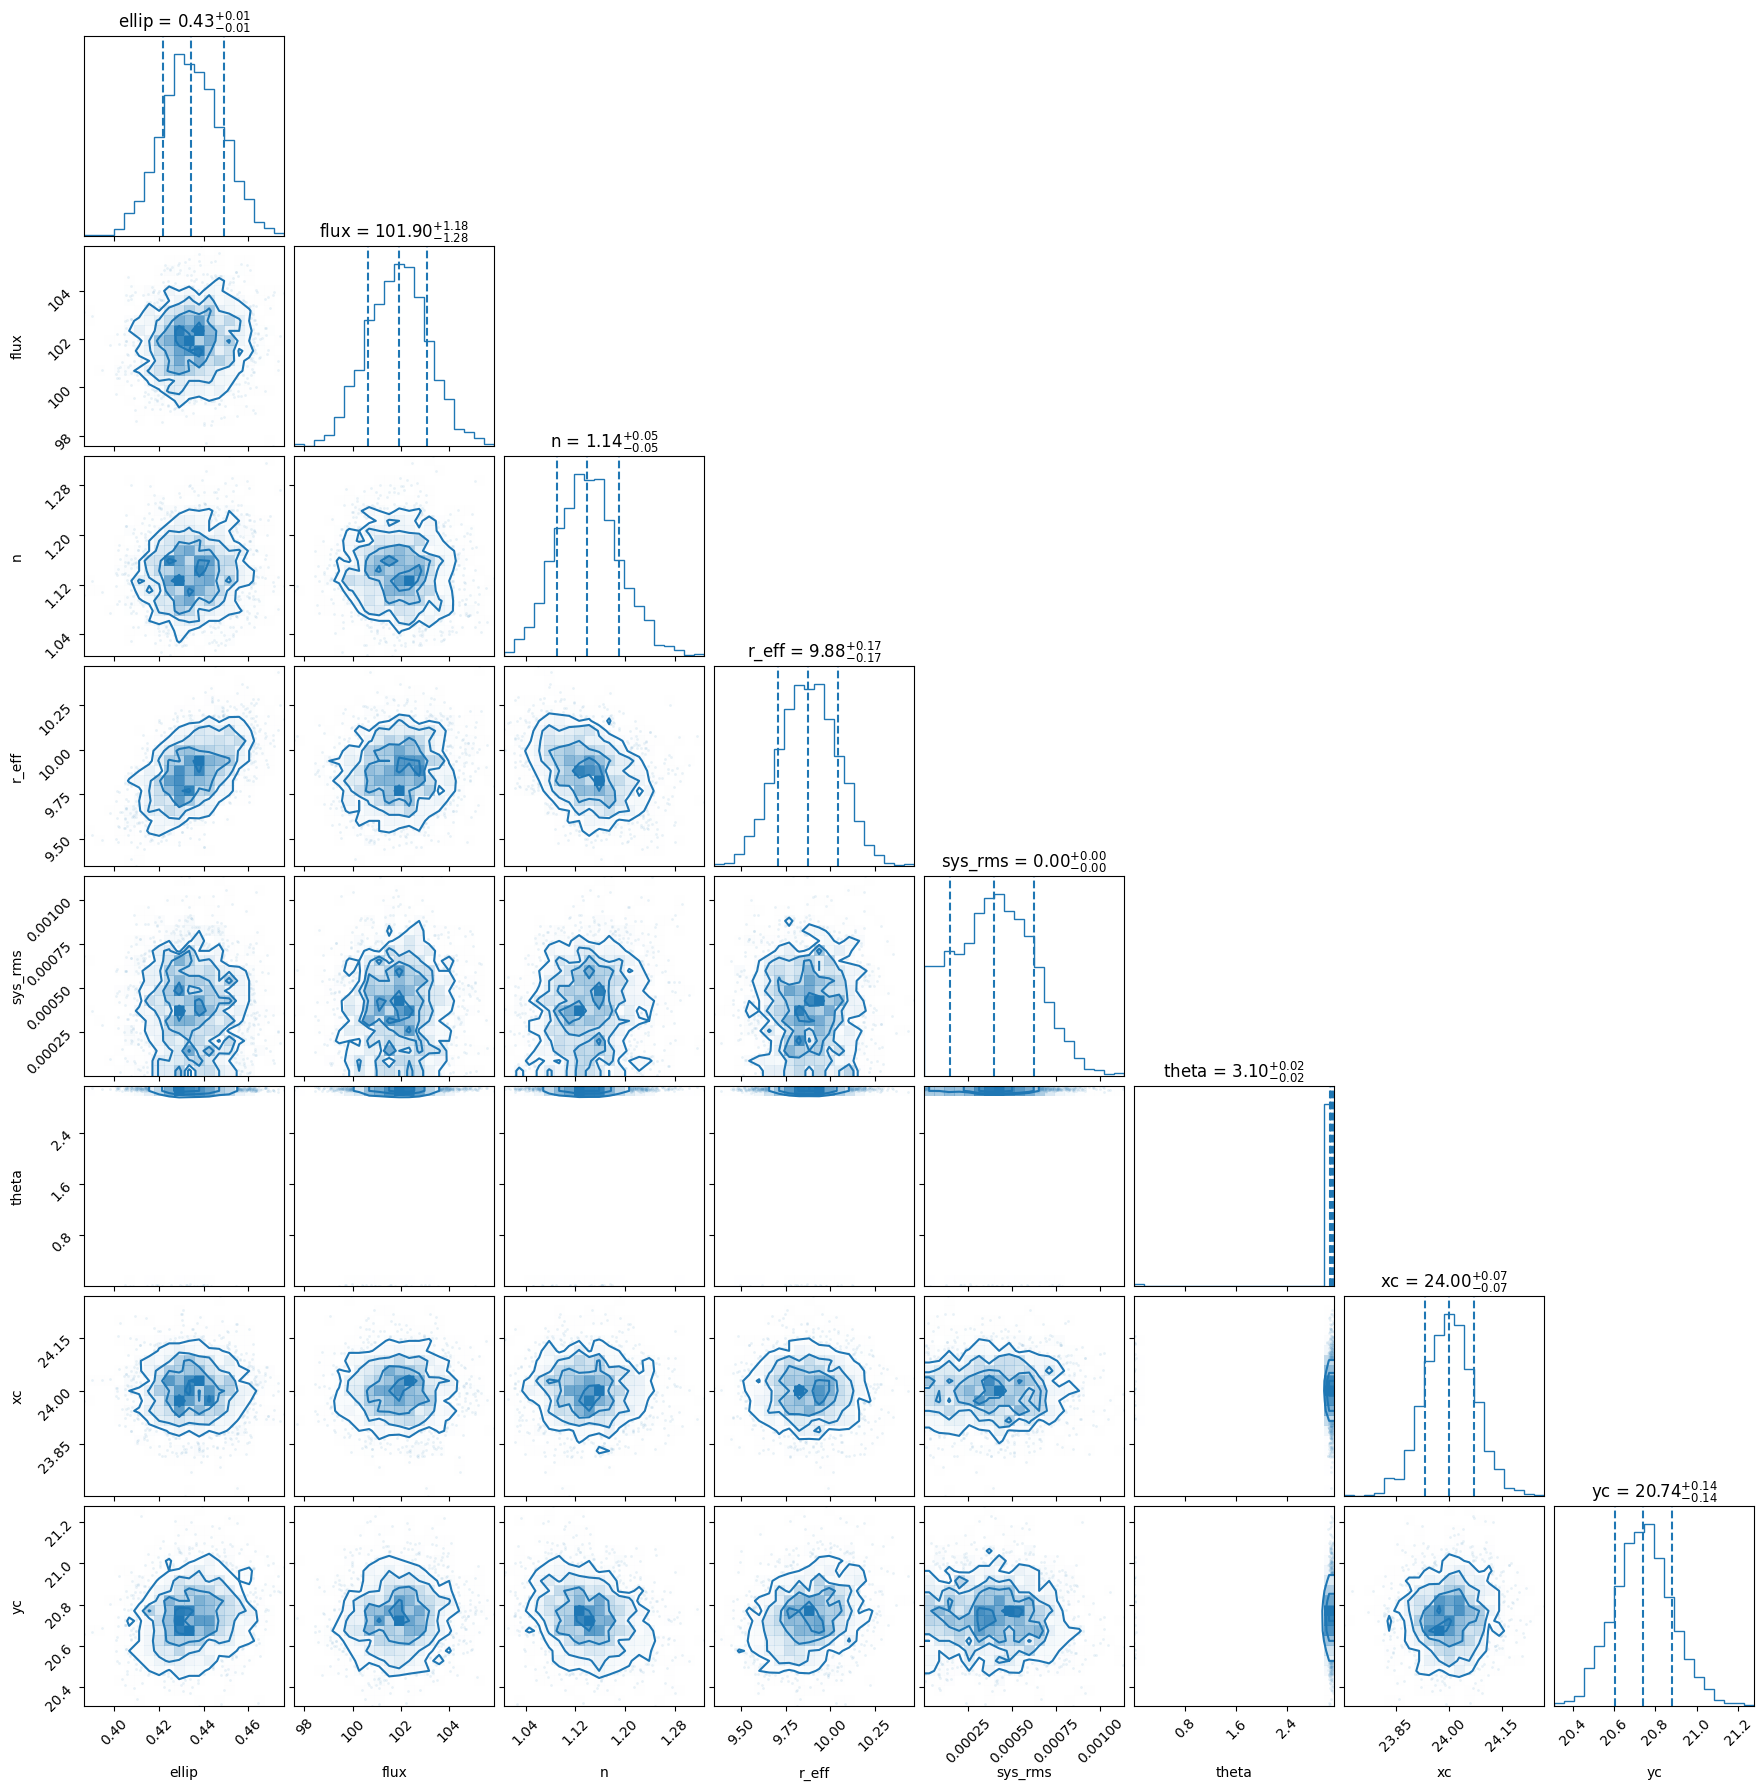

load data for filter F444W
data looks good!
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 101.90, sigma = 20.19
xc ---  Normal w/ mu = 24.09, sigma = 1.00
yc ---  Normal w/ mu = 20.79, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 10.27, sigma = 6.41, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.50 -> 4.50
sky type - None



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:144: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:25<00:00, 79.00it/s, 7 steps of size 3.51e-01. acc. prob=0.86]  


              0.16       0.50       0.84
ellip     0.378614   0.393922   0.409387
flux     91.759257  92.964085  94.022964
n         1.164747   1.223061   1.278960
r_eff     9.575371   9.749541   9.927072
sys_rms   0.000129   0.000388   0.000662
theta     0.030847   3.117529   3.134086
xc       23.894278  23.971586  24.047802
yc       20.326859  20.464135  20.589632


C:\Users\kings\AppData\Local\Temp\ipykernel_13280\3612776576.py:37: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')


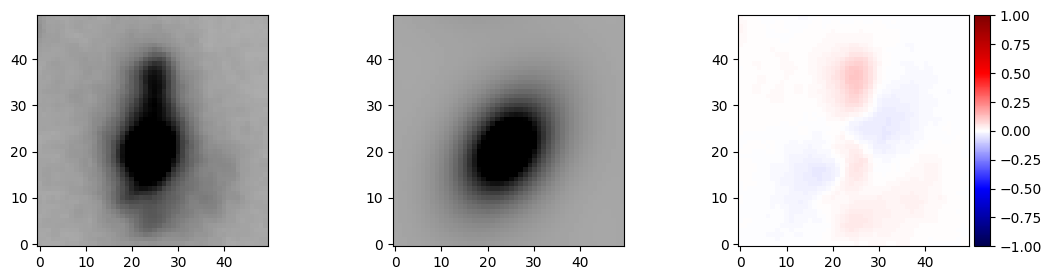

corner of F444W


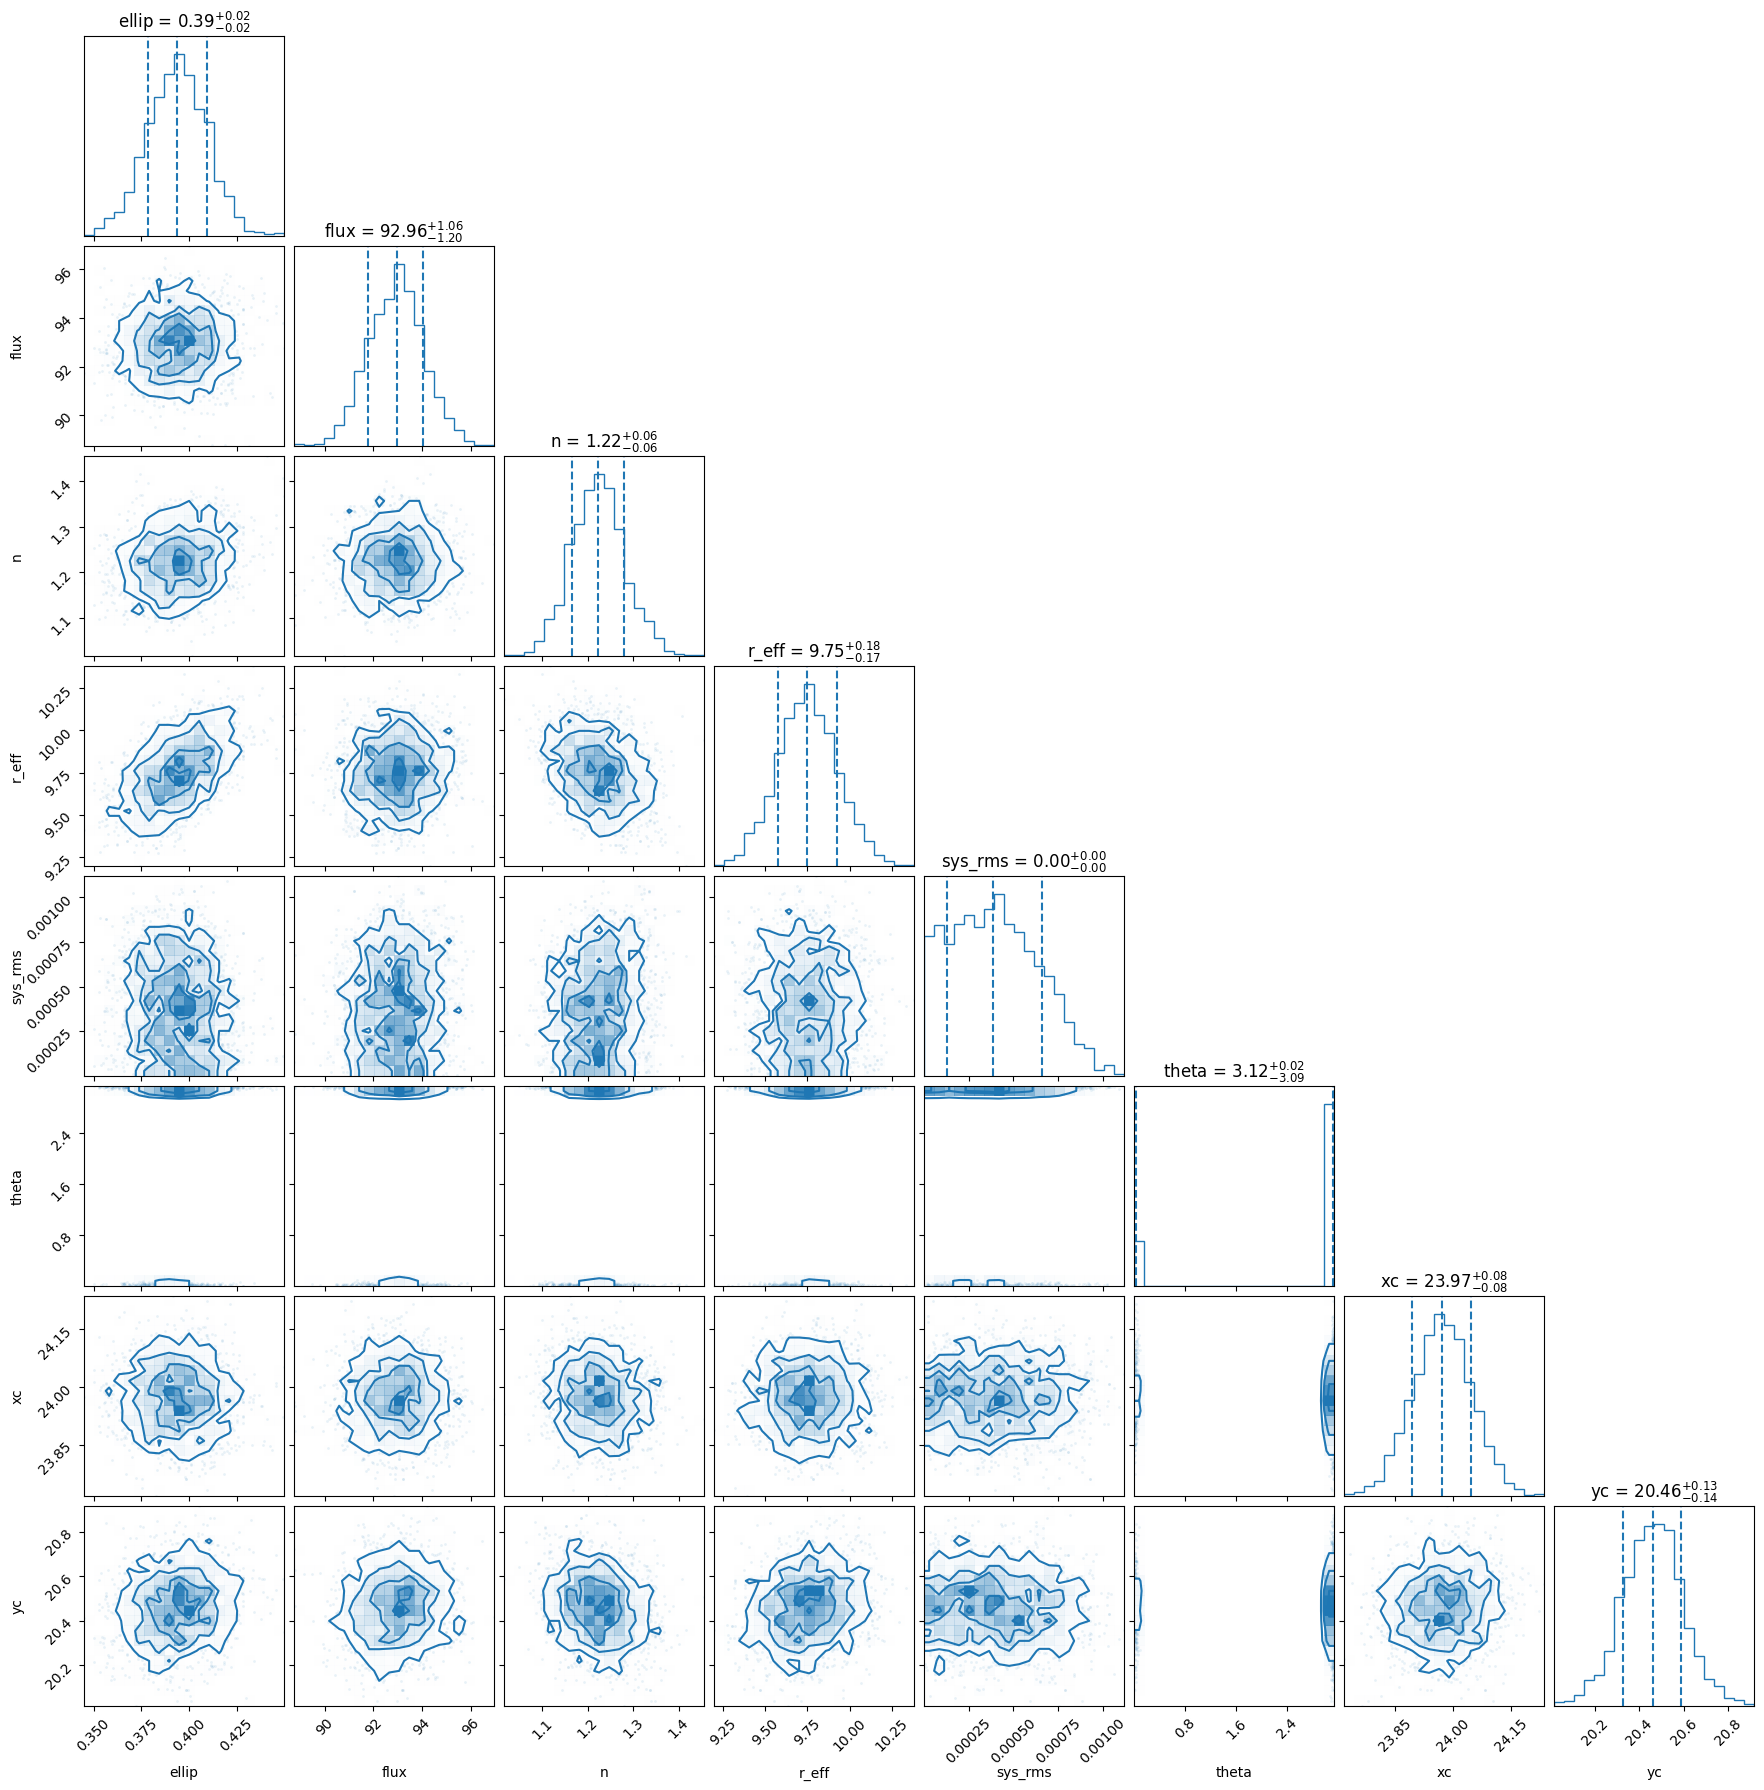

In [29]:
# single component fit
filter_list = ["f090w", "f115w", "f150w", "f182m", "f200w", "f210m", "f277w", "f356w", "f410m", "f444w"]

for ii_f in filter_list:

    print("=============================================================================")
    # load data
    print("load data for filter", ii_f.upper())
    im, mask, sig, psf = load_data(filter=ii_f)
    
    # get priors
    props = SourceProperties(im, mask=mask) # Optional mask
    prior = props.generate_prior('sersic', # Other profiles inclues 'exp', 'dev' and 'pointsource'
                          sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background    
    prior.set_uniform_prior('n', 0.5, 4.5)
    print(prior)

    # setup fitter
    fitter = FitSingle(data=im, rms=sig ,mask=mask, psf=psf, prior=prior, loss_func=student_t_loss_free_sys)
    
    # MAP
    # map_params = fitter.find_MAP(rkey=PRNGKey(1000))
    # fig, ax = plot_residual(im, map_params["model"], mask=mask, vmin=-1, vmax=1)
    # plt.show()

    # sampling
    fitter.sample(rkey = PRNGKey(1000))
    print(fitter.sampling_results.retrieve_param_quantiles(return_dataframe=True))

    # plot residual
    summary = fitter.sampling_results.summary()
    dict = {}
    for a, b in zip(summary.index, summary["mean"]):
        dict[a] = b
    # dict.pop('sys_scatter')
    
    bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type = 'sersic')
    fig, ax = plot_residual(im, bf_model, mask=mask, vmin=-1, vmax=1)
    plt.show()
    
    # plot corner
    print("corner of", ii_f.upper())
    fig = fitter.sampling_results.corner(color='C0') 
    plt.show()
    print("=============================================================================")
    
    # save results
    fitter.sampling_results.save_result(os.path.join(path_wdir, 'Output', 'fit_' + ii_f + '.asdf'))


Multi-Band Sersic Fitting
============================

[Sandro's Code]
==========================

In [ ]:
# double component fit

for ii_f in filter_list:

    print("=============================================================================")
    # load data
    print("load data for filter", ii_f.upper())
    im, mask, sig, psf = load_data(filter=ii_f)
    
    # get priors
    props = SourceProperties(im, mask=mask) # Optional mask
    prior = props.generate_prior('sersic_exp', # Other profiles inclues 'exp', 'dev' and 'pointsource'
                          sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background    
    prior.set_uniform_prior('r_eff_1', 0.5, 5.0)
    prior.set_uniform_prior('r_eff_2', 10.0, 20.0)
    prior.set_uniform_prior('n', 2.0, 4.5)  # Sersic index of the central component
    print(prior)

    # setup fitter
    fitter = FitSingle(data=im, rms=sig ,mask=mask, psf=psf, prior=prior, loss_func=student_t_loss_free_sys)
    
    # MAP
    # map_params = fitter.find_MAP(rkey=PRNGKey(1000))
    # fig, ax = plot_residual(im, map_params["model"], mask=mask, vmin=-1, vmax=1)
    # plt.show()

    # sampling
    fitter.sample(rkey = PRNGKey(1000))
    print(fitter.sampling_results.retrieve_param_quantiles(return_dataframe=True))

    # plot residual
    summary = fitter.sampling_results.summary()
    dict = {}
    for a, b in zip(summary.index, summary["mean"]):
        dict[a] = b

    bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict, profile_type="sersic_exp")
    fig, ax = plot_residual(im, bf_model, mask=mask, vmin=-1, vmax=1)
    plt.show()
    
    # plot corner
    print("corner of", ii_f.upper())
    fig = fitter.sampling_results.corner(color='C0') 
    plt.show()
    print("=============================================================================")
    
    # save results
    fitter.sampling_results.save_result(os.path.join(path_wdir, 'output/double_fit_' + ii_f + '.asdf'))


# Fit multiple bands simultaneously

In [ ]:
band_list = filter_list[1:] # ignore shortest band?
#wv_list = np.array([filterlist[1:][ii].wave_effective/1e4 for ii in range(len(band_list))])
wv_list = 1.0/np.array([filterlist[1:][ii].wave_effective/1e4 for ii in range(len(band_list))])


In [ ]:

psf_dict = {}
img_dict = {}
rms_dict = {}
prior_dict = {}
prior_2comp_dict = {}

for j,band in enumerate(band_list):
    # load data
    im, mask, sig, psf = load_data(filter=band)
    psf_dict[band] = psf
    img_dict[band] = im
    rms_dict[band] = sig
    # generate prior 1
    props = SourceProperties(im, mask=mask) # Optional mask
    prior = props.generate_prior('sersic', # Other profiles inclues 'exp', 'dev' and 'pointsource'
                          sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background    
    prior.set_uniform_prior('n', 0.5, 4.5)
    prior_dict[band] = prior
    # generate prior 2
    prior = props.generate_prior('sersic_exp', # Other profiles inclues 'exp', 'dev' and 'pointsource'
                          sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background    
    prior.set_uniform_prior('r_eff_1', 0.5, 5.0)
    prior.set_uniform_prior('r_eff_2', 10.0, 20.0)
    prior.set_uniform_prior('n', 2.0, 4.5)  # Sersic index of the central component
    prior_2comp_dict[band] = prior


In [ ]:

# loop through and run fit in each of the 3 bands
fitter_dict = {}
ind_res_dict = {}
fitter2_dict = {}
ind2_res_dict = {}
rkey = jax.random.PRNGKey(19)
for band in band_list:
    rkey,_ = jax.random.split(rkey, 2) # use differeny random number key for each run
    # single component fit
    fitter_cur = FitSingle(
        data=img_dict[band],
        rms = rms_dict[band],
        psf = psf_dict[band],
        prior = prior_dict[band],
        mask = mask.copy(),
        loss_func = student_t_loss_free_sys
    )
    print (f'Running fit - {band}')
    ind_res_cur = fitter_cur.estimate_posterior(rkey = rkey)
    ind_res_dict[band] = ind_res_cur.retrieve_med_std()
    fitter_dict[band] = fitter_cur
    # double component fit
    fitter_cur = FitSingle(
        data=img_dict[band],
        rms = rms_dict[band],
        psf = psf_dict[band],
        prior = prior_2comp_dict[band],
        mask = mask.copy(),
        loss_func = student_t_loss_free_sys
    )
    print (f'Running fit - {band}')
    ind_res_cur = fitter_cur.estimate_posterior(rkey = rkey)
    ind2_res_dict[band] = ind_res_cur.retrieve_med_std()
    fitter2_dict[band] = fitter_cur




## Single component

In [ ]:
wv_to_save = np.linspace(min(wv_list),max(wv_list), num = 50)

# single component
MultiFitter = FitMultiBandPoly(fitter_list=[fitter_dict[b] for b in band_list],
                               wavelengths=wv_list,
                               band_names= band_list,
                               linked_params=['n','ellip','r_eff'],
                               const_params=['xc','yc','theta'],
                               wv_to_save= wv_to_save,
                               poly_order = 2)
rkey,_ = jax.random.split(rkey,2)
multires = MultiFitter.estimate_posterior(method = 'svi-flow', rkey = rkey)

link_params = [f'{param}_{b}' for b in band_list for param in ['r_eff','n','ellip']] # Look at posteriors of "linked" parameters
multi_res_dict = multires.retrieve_med_std()
az.summary(multires.idata, var_names=link_params)



In [ ]:
titles = ["Sersic index n", "ellipticity", r"$R_{\rm eff}$ [kpc]"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 2.7))

for j, param in enumerate(['n','ellip','r_eff']):
    ax = axes[j]

    med_ind = np.array([ind_res_dict[b][param][0] for b in band_list])
    err_ind = np.array([ind_res_dict[b][param][1] for b in band_list])

    med_multi = np.array([multi_res_dict[f'{param}_{b}'][0] for b in band_list])
    err_multi = np.array([multi_res_dict[f'{param}_{b}'][1] for b in band_list])

    if (param == 'r_eff'):
        conversion = kpc_per_arcsec*pix_scale
    else:
        conversion = 1.0
    
    param_smooth = multires.idata.posterior[f'{param}_at_wv'].data.squeeze()
    ax.plot(1/wv_to_save, conversion*param_smooth[:20].T, '-', color='crimson', alpha = 0.1)
    ax.errorbar(1/wv_list, conversion*med_ind, yerr=conversion*err_ind, fmt = 'o', color = 'k', label = 'individual')
    ax.errorbar(1/wv_list+0.01, conversion*med_multi, yerr=conversion*err_multi, fmt = 'o', color = 'crimson', markeredgecolor='gray', label = 'joint')
    # ax.set_title(param, fontsize = 14)
    ax.set_xlabel(r'$\lambda_{\rm obs}$ [$\mu$m]')
    ax.set_xlim([1, 5])
    ax.set_ylabel(titles[j])

axes[0].set_ylim([0.8, 5.2])
axes[1].set_ylim([0.0, 1])
axes[2].set_ylim([0.5, 3])
axes[0].legend(frameon=False)

axes[0].tick_params(width=1.5, length=7)
plt.setp(axes[0].spines.values(), lw=1.5)
axes[1].tick_params(width=1.5, length=7)
plt.setp(axes[1].spines.values(), lw=1.5)
axes[2].tick_params(width=1.5, length=7)
plt.setp(axes[2].spines.values(), lw=1.5)

plt.subplots_adjust(wspace=0.3, hspace=0.05)
plt.savefig(path_fig + 'joint.pdf', bbox_inches='tight')
plt.show()


In [ ]:
# extract best fit and save

ind_fit = {}
joint_fit = {}
ind_err_fit = {}
joint_err_fit = {}

for j,param in enumerate(['flux', 'n', 'ellip', 'r_eff']):

    ind_fit[param] = [ind_res_dict[b][param][0] for b in band_list]
    ind_err_fit[param] = [ind_res_dict[b][param][1] for b in band_list]

    joint_fit[param] = [multi_res_dict[f'{param}_{b}'][0] for b in band_list]
    joint_err_fit[param] = [multi_res_dict[f'{param}_{b}'][1] for b in band_list]





In [ ]:
param = 'ellip'
conv = 1.0 #kpc_per_arcsec*pix_scale
print(conv*np.round(ind_fit[param],2), conv*np.round(ind_err_fit[param],2))
print(conv*np.round(joint_fit[param],2), conv*np.round(joint_err_fit[param],2))


## Double component

In [ ]:
wv_to_save = np.linspace(min(wv_list),max(wv_list), num = 50)

# double component
MultiFitter = FitMultiBandPoly(fitter_list=[fitter2_dict[b] for b in band_list],
                               wavelengths=wv_list,
                               band_names= band_list,
                               linked_params=['f_1'],
                               const_params=['xc','yc','n','theta','r_eff_1','ellip_1','r_eff_2','ellip_2'],
                               wv_to_save= wv_to_save,
                               poly_order = 2)
rkey,_ = jax.random.split(rkey,2)
multires = MultiFitter.estimate_posterior(method = 'svi-flow', rkey = rkey)

link_params = [f'{param}_{b}' for b in band_list for param in ['f_1']] # Look at posteriors of "linked" parameters
multi2_res_dict = multires.retrieve_med_std()
az.summary(multires.idata, var_names=link_params)


In [ ]:
az.summary(multires.idata, var_names=['n', 'r_eff_1','r_eff_2'])


In [ ]:
print(3.369*kpc_per_arcsec*pix_scale, 0.029*kpc_per_arcsec*pix_scale)
print(11.160*kpc_per_arcsec*pix_scale, 0.331*kpc_per_arcsec*pix_scale)



In [ ]:
titles = ["B/T"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.7))

for j, param in enumerate(['f_1']):
    ax = axes

    med_ind = np.array([ind2_res_dict[b][param][0] for b in band_list])
    err_ind = np.array([ind2_res_dict[b][param][1] for b in band_list])

    med_multi = np.array([multi2_res_dict[f'{param}_{b}'][0] for b in band_list])
    err_multi = np.array([multi2_res_dict[f'{param}_{b}'][1] for b in band_list])

    if (param == 'r_eff_1') | (param == 'r_eff_2'):
        conversion = kpc_per_arcsec*pix_scale
    else:
        conversion = 1.0
    
    param_smooth = multires.idata.posterior[f'{param}_at_wv'].data.squeeze()
    ax.plot(1/wv_to_save, conversion*param_smooth[:20].T, '-', color='crimson', alpha = 0.1)
    ax.errorbar(1/wv_list, conversion*med_ind, yerr=conversion*err_ind, fmt = 'o', color = 'k', label = 'individual')
    ax.errorbar(1/wv_list+0.01, conversion*med_multi, yerr=conversion*err_multi, fmt = 'o', color = 'crimson', markeredgecolor='gray', label = 'joint')
    # ax.set_title(param, fontsize = 14)
    ax.set_xlabel(r'$\lambda_{\rm obs}$ [$\mu$m]')
    ax.set_xlim([1, 5])
    ax.set_ylabel(titles[j])

axes.set_ylim([0.0, 1])
axes.legend(frameon=False)

axes.tick_params(width=1.5, length=7)
plt.setp(axes.spines.values(), lw=1.5)

plt.subplots_adjust(wspace=0.3, hspace=0.05)
plt.savefig(path_fig + 'joint_2comp.pdf', bbox_inches='tight')
plt.show()


In [ ]:
# extract best fit and save

ind2_fit = {}
joint2_fit = {}
ind2_err_fit = {}
joint2_err_fit = {}

for j,param in enumerate(['f_1', 'flux']):

    ind2_fit[param] = [ind2_res_dict[b][param][0] for b in band_list]
    ind2_err_fit[param] = [ind2_res_dict[b][param][1] for b in band_list]

    joint2_fit[param] = [multi2_res_dict[f'{param}_{b}'][0] for b in band_list]
    joint2_err_fit[param] = [multi2_res_dict[f'{param}_{b}'][1] for b in band_list]




# Plot profile

In [ ]:
# UVJ spatially resolved

# define filters
# U ~ F150W
# V ~ F200W
# J ~ F444W
#ii_u = 1
#ii_v = 2
#ii_j = 6
ii_u = 0
ii_v = 1
ii_j = 5

# define redshift and apertures

apertures = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]  # in kpc

# setup Sersic profiles
#ser_u = Sersic1D(amplitude=quant[filter_list[ii_u]]['flux']['q50'], r_eff=quant[filter_list[ii_u]]['r_eff']['q50'], n=quant[filter_list[ii_u]]['n']['q50'])
#ser_v = Sersic1D(amplitude=quant[filter_list[ii_v]]['flux']['q50'], r_eff=quant[filter_list[ii_v]]['r_eff']['q50'], n=quant[filter_list[ii_v]]['n']['q50'])
#ser_j = Sersic1D(amplitude=quant[filter_list[ii_j]]['flux']['q50'], r_eff=quant[filter_list[ii_j]]['r_eff']['q50'], n=quant[filter_list[ii_j]]['n']['q50'])

# setup Sersic profiles
ser_u = Sersic1D(amplitude=joint_fit['flux'][ii_u], r_eff=joint_fit['r_eff'][ii_u], n=joint_fit['n'][ii_u])
ser_v = Sersic1D(amplitude=joint_fit['flux'][ii_v], r_eff=joint_fit['r_eff'][ii_v], n=joint_fit['n'][ii_v])
ser_j = Sersic1D(amplitude=joint_fit['flux'][ii_j], r_eff=joint_fit['r_eff'][ii_j], n=joint_fit['n'][ii_j])

# setup Sersic profiles
#ser_v = Sersic1D(amplitude=ind_fit['flux'][ii_v], r_eff=ind_fit['r_eff'][ii_v], n=ind_fit['n'][ii_v])
#ser_u = Sersic1D(amplitude=ind_fit['flux'][ii_u], r_eff=ind_fit['r_eff'][ii_u], n=ind_fit['n'][ii_u])
#ser_j = Sersic1D(amplitude=ind_fit['flux'][ii_j], r_eff=ind_fit['r_eff'][ii_j], n=ind_fit['n'][ii_j])





In [ ]:
# plot profiles

r = np.arange(0, 100, 0.01)

fig, ax = plt.subplots(figsize=(6, 4.5))

ax.plot(r, ser_u(r), lw=2, color='dodgerblue', label='F150W (rest-frame U)')
ax.plot(r, ser_v(r), lw=2, color='darkgreen', label='F200W (rest-frame V)')
ax.plot(r, ser_j(r), lw=2, color='crimson', label='F444W (rest-frame J)')

ax.legend(frameon=False, fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Radius", fontsize=16)
ax.set_ylabel("Surface Brightness", fontsize=16)
ax.set_xlim([1, 100])
ax.set_ylim([1e-2, 10000])

plt.subplots_adjust(wspace=0.25, hspace=0.05)
plt.savefig(path_fig + 'profiles.pdf', bbox_inches='tight')
plt.show()


# UVJ in apertures

In [ ]:
uvj_table = Table.read("/Users/sandrotacchella/ASTRO/JWST/uds-7329/pysersic/output/uvj_evolution.dat", format='ascii')

In [ ]:
# UVJ color correction

#I get UVJ magnitudes (calculated in rest-frame):
u_rest = 27.37157
v_rest = 25.60628
j_rest = 24.46579
#And the filters (calculated in observed frame):
F150W = 24.26918
F200W = 22.84880
F444W = 21.53884

u_v_corr = (u_rest-v_rest)-(F150W-F200W)
v_j_corr = (v_rest-j_rest)-(F200W-F444W)
print("u_v_corr =", u_v_corr)
print("v_j_corr =", v_j_corr)

color_sed = [u_rest-v_rest, v_rest-j_rest]
print("UVJ color =", color_sed)

In [ ]:
def get_flux(ap, ser):
    idx = (r < ap/kpc_per_arcsec/pix_scale)
    return(2*np.pi*np.trapz(r[idx] * ser(r)[idx], r[idx]))


flux_ap_u = []
flux_ap_v = []
flux_ap_j = []

for ap in apertures:
    flux_ap_u.append(get_flux(ap, ser_u))
    flux_ap_v.append(get_flux(ap, ser_v))
    flux_ap_j.append(get_flux(ap, ser_j))

flux_ap_u = np.append(flux_ap_u[0], np.diff(flux_ap_u))
flux_ap_v = np.append(flux_ap_v[0], np.diff(flux_ap_v))
flux_ap_j = np.append(flux_ap_j[0], np.diff(flux_ap_j))



In [ ]:
# spatially resolved color
mag_uv = -2.5*np.log10(flux_ap_u/flux_ap_v)
mag_vj = -2.5*np.log10(flux_ap_v/flux_ap_j)

print("mag_uv =", mag_uv)
print("mag_vj =", mag_vj)



In [ ]:
# integrated photometry

uv_global = -2.5* np.log10(joint_fit['flux'][ii_u]/joint_fit['flux'][ii_v])
uv_global_err = 2.5**2/np.log(10)**2 * ((joint_err_fit['flux'][ii_u]/joint_fit['flux'][ii_u])**2 + (joint_err_fit['flux'][ii_v]/joint_fit['flux'][ii_v])**2)
vj_global = -2.5* np.log10(joint_fit['flux'][ii_v]/joint_fit['flux'][ii_j])
vj_global_err = 2.5**2/np.log(10)**2 * ((joint_err_fit['flux'][ii_v]/joint_fit['flux'][ii_v])**2 + (joint_err_fit['flux'][ii_j]/joint_fit['flux'][ii_j])**2)

print(uv_global, vj_global)
print(uv_global_err, vj_global_err)


In [ ]:
# get UVJ box

def UVJ_boundary(VJ_color):
    if (VJ_color > 1.6):
        return(3.0)
    else:
        UV_color = 0.88*VJ_color+0.49
        if (UV_color < 1.3):
            return(1.3)
        else:
            return(UV_color)

        
VJ_color_boundary = np.linspace(-1.0, 3.0, num=10**4)
UV_color_boundary = []

for col in VJ_color_boundary:
    UV_color_boundary.append(UVJ_boundary(col))

In [ ]:
joint2_fit

In [ ]:
# integrated photometry

#uv_global = -2.5* np.log10(quant[filter_list[ii_u]]['flux']['q50']/quant[filter_list[ii_v]]['flux']['q50'])
#vj_global = -2.5* np.log10(quant[filter_list[ii_v]]['flux']['q50']/quant[filter_list[ii_j]]['flux']['q50'])

uv_bulge = -2.5* np.log10(joint2_fit['f_1'][ii_u]*joint2_fit['flux'][ii_u]/(joint2_fit['f_1'][ii_v]*joint2_fit['flux'][ii_v]))
vj_bulge = -2.5* np.log10(joint2_fit['f_1'][ii_v]*joint2_fit['flux'][ii_v]/(joint2_fit['f_1'][ii_j]*joint2_fit['flux'][ii_j]))

uv_disc = -2.5* np.log10((1-joint2_fit['f_1'][ii_u])*joint2_fit['flux'][ii_u]/((1-joint2_fit['f_1'][ii_v])*joint2_fit['flux'][ii_v]))
vj_disc = -2.5* np.log10((1-joint2_fit['f_1'][ii_v])*joint2_fit['flux'][ii_v]/((1-joint2_fit['f_1'][ii_j])*joint2_fit['flux'][ii_j]))


print(uv_global, vj_global)
print(uv_bulge, vj_bulge)
print(uv_disc, vj_disc)



In [ ]:
uvj_table.keys()

In [ ]:
idx1 = np.argmin(np.abs(uvj_table['age']-0.05))
idx2 = np.argmin(np.abs(uvj_table['age']-0.1))
idx3 = np.argmin(np.abs(uvj_table['age']-0.5))
idx4 = np.argmin(np.abs(uvj_table['age']-1.0))
idx5 = np.argmin(np.abs(uvj_table['age']-2.0))
idx6 = np.argmin(np.abs(uvj_table['age']-3.0))

idx_list = [idx1, idx2, idx3, idx4, idx5, idx6]
age_list = ["0.05 Gyr", "0.1 Gyr", "0.5 Gyr", "1 Gyr", "2 Gyr", "3 Gyr"]

In [ ]:
mag_err = 0.1
mag2_err = 0.2


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6.0, 4.5))

# plot UVJ box
ax1.plot(VJ_color_boundary, UV_color_boundary, '-', lw=2.0, color='black')

# plot color track
p1, = ax1.plot(uvj_table['vj_ssp'], uvj_table['uv_ssp'], '-', lw=1.0, color='orange', label='SSP')
p2, = ax1.plot(uvj_table['vj_csfh'], uvj_table['uv_csfh'], '-', lw=1.0, color='teal', label='const. SFH')
for ii, idx in enumerate(idx_list):
    ax1.plot(uvj_table['vj_ssp'][idx], uvj_table['uv_ssp'][idx], 'D', color='orange')
    ax1.plot(uvj_table['vj_csfh'][idx], uvj_table['uv_csfh'][idx], 'D', color='teal')
    ax1.text(uvj_table['vj_csfh'][idx]+0.05, uvj_table['uv_csfh'][idx]-0.02, age_list[ii], fontsize=8, va='center')

# plot dust vector
dvj = np.median(uvj_table['vj_ssp_wdust']-uvj_table['vj_ssp'])
duv = np.median(uvj_table['uv_ssp_wdust']-uvj_table['uv_ssp'])
print(dvj, duv)
#ax1.annotate("", xy=(dvj, duv), xytext=(1.2, 1.0)) #, arrowprops=dict(arrowstyle="->"))
ax1.arrow(1, 0.7, dvj, duv, length_includes_head=True, head_width=0.1, head_length=0.1, color='black')
ax1.text(1, 0.8, r"$\mathrm{A}_{\rm V}=1~\mathrm{mag}$", rotation=34)

# plot bulge and disc
p3, _, _ = ax1.errorbar(vj_global+v_j_corr, uv_global+u_v_corr, fmt='p', xerr=mag_err, yerr=mag_err, ms=10, color='black', label='model photometry')
p4, _, _ = ax1.errorbar(vj_bulge+v_j_corr, uv_bulge+u_v_corr, fmt='o', xerr=mag_err, yerr=mag_err, ms=8, color='crimson', label='bulge')
p5, _, _ = ax1.errorbar(vj_disc+v_j_corr, uv_disc+u_v_corr, fmt='s', xerr=mag_err, yerr=mag_err, ms=8, color='dodgerblue', label='disc')


#ax1.plot(mag_integrated[1]-mag_integrated[2]+v_j_corr, mag_integrated[2]-mag_integrated[6]+u_v_corr, 'x', ms=10, color='black', label='total aperture photometry')
p6, = ax1.plot(color_sed[1], color_sed[0], 'X', ms=8, color='black', label='aperture photometry')

# radial profile
ax1.plot(mag_vj+v_j_corr, mag_uv+u_v_corr, '-', lw=1, color='black')
ax1.errorbar(mag_vj+v_j_corr, mag_uv+u_v_corr, xerr=mag2_err, yerr=mag2_err, color='gray', alpha=0.3)
sc = ax1.scatter(mag_vj+v_j_corr, mag_uv+u_v_corr, c=apertures, s=60, cmap='cool_r', vmin=0.0, vmax=7, zorder=10, edgecolors='gray', label='radial profile')

cbar = plt.colorbar(sc, ticks=[0, 2, 4, 6])
cbar.set_label(r'radial distance [kpc]', rotation=270, fontsize=16, va='bottom')
cbar.ax.minorticks_off()

#ax1.legend(frameon=False, loc=2)

l1 = ax1.legend([p1, p2], ['SSP', 'const. SFH'], loc=4, frameon=False, fontsize=12)
l2 = ax1.legend([p3, p6, sc, p4, p5], ['model photometry', 'aperture photometry', 'radial profile', 'bulge', 'disc'], loc=2, frameon=False)
ax1.add_artist(l1)

ax1.set_ylabel(r'$\mathrm{U}\/-\/\mathrm{V}\/\/\/[\mathrm{AB\/\/mag}]$', fontsize=16)
ax1.set_xlabel(r'$\mathrm{V}\/-\/\mathrm{J}\/\/\/[\mathrm{AB\/\/mag}]$', fontsize=16)
ax1.set_xlim([-0.2, 2])
ax1.set_ylim([0.0, 2.2])

ax1.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0])
ax1.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])

ax1.tick_params(width=2, length=7)
plt.setp(ax1.spines.values(), lw=2)

plt.subplots_adjust(wspace=0.25, hspace=0.05)
plt.savefig(path_fig + 'UVJ_spatial.pdf', bbox_inches='tight')
plt.show()


# OLD

In [ ]:
# load all fits

af_all = {}

for ii_f in filter_list:
    af_all[ii_f] = asdf.open(os.path.join(path_wdir, 'output/fit_' + ii_f + '.asdf'))

af_all

In [ ]:
method = 0

prop = ['flux', 'ellip', 'n', 'r_eff', 'theta', 'xc', 'yc']
quant = {}

for ii_f in filter_list:
    quant[ii_f] = {}
    for p in prop:
        quant[ii_f][p] = {}
        quant[ii_f][p]['q16'] = np.percentile(af_all[ii_f].tree['posterior'][p][method], 16)
        quant[ii_f][p]['q50'] = np.percentile(af_all[ii_f].tree['posterior'][p][method], 50)
        quant[ii_f][p]['q84'] = np.percentile(af_all[ii_f].tree['posterior'][p][method], 84)
        quant[ii_f][p]['err_low'] = quant[ii_f][p]['q50']-quant[ii_f][p]['q16']
        quant[ii_f][p]['err_up'] = quant[ii_f][p]['q84']-quant[ii_f][p]['q50']
        




In [ ]:
# load all fits

af_all = {}

for ii_f in filter_list:
    af_all[ii_f] = asdf.open(os.path.join(path_wdir, 'output/double_fit_' + ii_f + '.asdf'))

af_all

In [ ]:
method = 0

prop = ['flux', 'n', 'r_eff_1', 'r_eff_2', 'f_1']
quant = {}

for ii_f in filter_list:
    quant[ii_f] = {}
    for p in prop:
        quant[ii_f][p] = {}
        quant[ii_f][p]['q16'] = np.percentile(af_all[ii_f].tree['posterior'][p][method], 16)
        quant[ii_f][p]['q50'] = np.percentile(af_all[ii_f].tree['posterior'][p][method], 50)
        quant[ii_f][p]['q84'] = np.percentile(af_all[ii_f].tree['posterior'][p][method], 84)
        quant[ii_f][p]['err_low'] = quant[ii_f][p]['q50']-quant[ii_f][p]['q16']
        quant[ii_f][p]['err_up'] = quant[ii_f][p]['q84']-quant[ii_f][p]['q50']
        


In [ ]:
# integrated photometry

uv_global = -2.5* np.log10(af_all[filter_list[ii_u]].tree['posterior']['flux'][method]/af_all[filter_list[ii_v]].tree['posterior']['flux'][method])
vj_global = -2.5* np.log10(af_all[filter_list[ii_v]].tree['posterior']['flux'][method]/af_all[filter_list[ii_j]].tree['posterior']['flux'][method])

uv_bulge = -2.5* np.log10(af_all[filter_list[ii_u]].tree['posterior']['f_1'][method]*af_all[filter_list[ii_u]].tree['posterior']['flux'][method]/(af_all[filter_list[ii_v]].tree['posterior']['f_1'][method]*af_all[filter_list[ii_v]].tree['posterior']['flux'][method]))
vj_bulge = -2.5* np.log10(af_all[filter_list[ii_v]].tree['posterior']['f_1'][method]*af_all[filter_list[ii_v]].tree['posterior']['flux'][method]/(af_all[filter_list[ii_j]].tree['posterior']['f_1'][method]*af_all[filter_list[ii_j]].tree['posterior']['flux'][method]))

uv_disc = -2.5* np.log10((1-af_all[filter_list[ii_u]].tree['posterior']['f_1'][method])*af_all[filter_list[ii_u]].tree['posterior']['flux'][method]/((1-af_all[filter_list[ii_v]].tree['posterior']['f_1'][method])*af_all[filter_list[ii_v]].tree['posterior']['flux'][method]))
vj_disc = -2.5* np.log10((1-af_all[filter_list[ii_v]].tree['posterior']['f_1'][method])*af_all[filter_list[ii_v]].tree['posterior']['flux'][method]/((1-af_all[filter_list[ii_j]].tree['posterior']['f_1'][method])*af_all[filter_list[ii_j]].tree['posterior']['flux'][method]))

uv_global, vj_global = np.percentile(uv_global, [16, 50, 84]), np.percentile(vj_global, [16, 50, 84])
uv_bulge, vj_bulge = np.percentile(uv_bulge, [16, 50, 84]), np.percentile(vj_bulge, [16, 50, 84])
uv_disc, vj_disc = np.percentile(uv_disc, [16, 50, 84]), np.percentile(vj_disc, [16, 50, 84])

print(uv_global, vj_global)
print(uv_bulge, vj_bulge)
print(uv_disc, vj_disc)


In [ ]:
from scipy.optimize import curve_fit

lm = np.array([9.25, 9.06, 8.78, 8.63, 8.55])
z = np.array([3.5, 4.5, 5.5, 6.5, 7.5])

def func(zred, alpha, m):
    return(alpha*np.log10(zred+1) + m)

popt, pcov = curve_fit(func, z, lm)

print(popt)
